# DecentNet from conv layer

    # additionally needed
    """
    
    position
    activated channels
    connection between channels
    
    """

    
        
        # this layer id
        layer_id = 0
        
        # within this layer, a whole filter can be deactivated
        # within a filter, single channels can be deactivated
        # within this layer, filters can be swapped
     
* pruning actually doesn"t work: https://discuss.pytorch.org/t/pruning-doesnt-affect-speed-nor-memory-for-resnet-101/75814   
* fine tune a pruned model: https://stackoverflow.com/questions/73103144/how-to-fine-tune-the-pruned-model-in-pytorch
* an actual pruning mechanism: https://arxiv.org/pdf/2002.08258.pdf

pip install:
    pytorch_lightning

# imports

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

import math
import warnings

import torch
import numpy as np
import torch.nn.functional as F

import torch
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F
# from torch.nn import init
from torch.nn.modules.module import Module
from torch.nn.modules.utils import _single, _pair, _triple, _reverse_repeat_tuple
from torch._torch_docs import reproducibility_notes

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
import os
import torchmetrics

from torch.nn.common_types import _size_1_t, _size_2_t, _size_3_t
from typing import Optional, List, Tuple, Union
import matplotlib.pyplot as plt


import sys 
sys.path.insert(0, "../helper")
from visualisation.feature_map import *

# Turn interactive plotting off
plt.ioff()

"""
import sys
sys.path.insert(0, "helper")
sys.path.insert(0, "/helper")
sys.path.insert(0, "./helper")
sys.path.insert(0, "../helper")
print(sys.path)
"""

# own module
#from visualisation.feature_map import *

import random

print()
print("cuda available:", torch.cuda.is_available())


debug_model = False

C:\Users\Christina\anaconda3\envs\chrisy\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")



cuda available: True


# Conv experiments

## conv2d layer (slightly adapted original)

In [2]:
class _ConvNd(torch.nn.Module):

    __constants__ = ['stride', 'padding', 'dilation', 'groups',
                     'padding_mode', 'output_padding', 'in_channels',
                     'out_channels', 'kernel_size']
    __annotations__ = {'bias': Optional[torch.Tensor]}

    def _conv_forward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]) -> Tensor:
        ...

    in_channels: int
    _reversed_padding_repeated_twice: List[int]
    out_channels: int
    kernel_size: Tuple[int, ...]
    stride: Tuple[int, ...]
    padding: Union[str, Tuple[int, ...]]
    dilation: Tuple[int, ...]
    transposed: bool
    output_padding: Tuple[int, ...]
    groups: int
    padding_mode: str
    weight: Tensor
    bias: Optional[Tensor]

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: Tuple[int, ...],
                 stride: Tuple[int, ...],
                 padding: Tuple[int, ...],
                 dilation: Tuple[int, ...],
                 transposed: bool,
                 output_padding: Tuple[int, ...],
                 groups: int,
                 bias: bool,
                 padding_mode: str,
                 device=None,
                 dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        print(factory_kwargs)
        super().__init__()
        if groups <= 0:
            raise ValueError('groups must be a positive integer')
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        valid_padding_strings = {'same', 'valid'}
        if isinstance(padding, str):
            if padding not in valid_padding_strings:
                raise ValueError(
                    "Invalid padding string {!r}, should be one of {}".format(
                        padding, valid_padding_strings))
            if padding == 'same' and any(s != 1 for s in stride):
                raise ValueError("padding='same' is not supported for strided convolutions")

        valid_padding_modes = {'zeros', 'reflect', 'replicate', 'circular'}
        if padding_mode not in valid_padding_modes:
            raise ValueError("padding_mode must be one of {}, but got padding_mode='{}'".format(
                valid_padding_modes, padding_mode))
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.transposed = transposed
        self.output_padding = output_padding
        self.groups = groups
        self.padding_mode = padding_mode
        # `_reversed_padding_repeated_twice` is the padding to be passed to
        # `F.pad` if needed (e.g., for non-zero padding types that are
        # implemented as two ops: padding + conv). `F.pad` accepts paddings in
        # reverse order than the dimension.
        if isinstance(self.padding, str):
            self._reversed_padding_repeated_twice = [0, 0] * len(kernel_size)
            if padding == 'same':
                for d, k, i in zip(dilation, kernel_size,
                                   range(len(kernel_size) - 1, -1, -1)):
                    total_padding = d * (k - 1)
                    left_pad = total_padding // 2
                    self._reversed_padding_repeated_twice[2 * i] = left_pad
                    self._reversed_padding_repeated_twice[2 * i + 1] = (
                        total_padding - left_pad)
        else:
            self._reversed_padding_repeated_twice = _reverse_repeat_tuple(self.padding, 2)

        if transposed:
            self.weight = Parameter(torch.empty(
                (in_channels, out_channels // groups, *kernel_size), **factory_kwargs))
            #self.importance = Parameter(torch.empty(
            #    (in_channels, out_channels // groups), **factory_kwargs))
            
        else:
            self.weight = Parameter(torch.empty(
                (out_channels, in_channels // groups, *kernel_size), **factory_kwargs))
            #self.importance = Parameter(torch.empty(
            #    (out_channels, in_channels // groups), **factory_kwargs))
            
        if bias:
            self.bias = Parameter(torch.empty(out_channels, **factory_kwargs))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()


class CustomConv2d(_ConvNd):
    
    # additionally needed
    """
    
    position
    activated channels
    connection between channels
    
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: _size_2_t,
        stride: _size_2_t = 1,
        padding: Union[str, _size_2_t] = 0,
        dilation: _size_2_t = 1,
        groups: int = 1,
        bias: bool = True,
        padding_mode: str = 'zeros',  # TODO: refine this type
        device=None,
        dtype=None
    ) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        kernel_size_ = _pair(kernel_size)
        stride_ = stride #_pair(stride)
        padding_ = padding if isinstance(padding, str) else _pair(padding)
        dilation_ = _pair(dilation)
        super().__init__(
            in_channels, out_channels, kernel_size_, stride_, padding_, dilation_,
            False, _pair(0), groups, bias, padding_mode, **factory_kwargs)
        
        # this layer id
        layer_id = 0
        
        # within this layer, a whole filter can be deactivated
        # within a filter, single channels can be deactivated
        # within this layer, filters can be swapped

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(k), 1/sqrt(k)), where k = weight.size(1) * prod(*kernel_size)
        # For more details see: https://github.com/pytorch/pytorch/issues/15314#issuecomment-477448573
        torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            if fan_in != 0:
                bound = 1 / math.sqrt(fan_in)
                init.uniform_(self.bias, -bound, bound)

    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        if self.padding_mode != 'zeros':
            s += ', padding_mode={padding_mode}'
        return s.format(**self.__dict__)

    def __setstate__(self, state):
        super().__setstate__(state)
        if not hasattr(self, 'padding_mode'):
            self.padding_mode = 'zeros'

    def _conv_forward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]):
        if self.padding_mode != 'zeros':
            return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                            weight, bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        
        # this is written in c++ - try not to change ...
        print(self.stride)
        return F.conv2d(input, weight, bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def forward(self, input: Tensor) -> Tensor:
        return self._conv_forward(input, self.weight, self.bias)



## model

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = CustomConv2d(1, 32, kernel_size=3, stride=1, padding=0, dilation=3)
        self.conv2 = CustomConv2d(32, 64, kernel_size=3, stride=1, padding=0, dilation=3)
        self.conv3 = CustomConv2d(64, 128, kernel_size=3, stride=1, padding=0, dilation=3)
        self.conv1x1 = CustomConv2d(128, 10, kernel_size=1, stride=1, padding=0, dilation=1)
        
        self.K = 100 
        self.L = 10 # last one
        self.num_of_bases = 1 # 3rd dim
        
        if False:
            self.conv1 = Conv2d(1, 32, kernel_size=3, stride=1, padding=0, dilation=3)
            self.conv2 = Conv2d(32, 64, kernel_size=3, stride=1, padding=0, dilation=3)
            self.conv3 = Conv2d(64, 128, kernel_size=3, stride=1, padding=0, dilation=3)
            self.conv1x1 = Conv2d(128, 10, kernel_size=1, stride=1, padding=0, dilation=1)
        #self.dropout1 = nn.Dropout(0.25)
        #self.dropout2 = nn.Dropout(0.5)
        # 4x16384
        # self.fc1 = nn.Linear(10*10*10, 10)
        #self.fc2 = nn.Linear(10, 10)
        
        #self.flat = nn.Flatten()
        
        self.fc3 = nn.Linear(10, 10)
        
        self.mish1 = torch.nn.Mish()
        self.mish2 = torch.nn.Mish()
        self.mish3 = torch.nn.Mish()
        self.mish1x1 = torch.nn.Mish()
        
        #self.sub_concept_pooling = nn.modules.MaxPool2d((self.K, 1), stride=(1,1))
        #self.instance_pooling = nn.modules.MaxPool2d((opt.num_of_bases, 1), stride=(1,1))
        
        self.flat = nn.Flatten()
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.mish1(x)
        
        x = self.conv2(x)
        x = self.mish2(x)
        
        x = self.conv3(x)
        x = self.mish3(x)
        
        x = self.conv1x1(x)
        x = self.mish1x1(x)
        
        # print(x.shape)
        
        #x = F.max_pool2d(x, 2)
        #x = self.dropout1(x)
        
        #print(x.size())
        #print(x.size()[2:])
        
        x = F.avg_pool2d(x, kernel_size=x.size()[2:])
        
        x = x.reshape(x.size(0), -1)
        x = self.fc3(x)
        
        # x = self.flat(x)
        
        #x = self.fc2(x)
        
        
        #x = x.view(-1, self.L, self.K, 10)
        
        # input, kernel_size, stride, padding, dilation, ceil_mode
        #x = self.sub_concept_pooling(x).view(-1, self.L, self.num_of_bases).permute(0,2,1).unsqueeze(1)
        
        # output = F.sigmoid(x)
        # x = x.reshape(x.size(0), -1)
        
        #x = torch.flatten(x, 1)
        # x = self.fc1(x)
        #x = F.relu(x)
        
        #x = self.dropout2(x)
        #x = self.fc2(x)
        #output = F.log_softmax(x, dim=1)
        
        x = self.sigmoid(x)
        
        return x





## normal run

In [4]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for i_batch, (data, target) in enumerate(train_loader):
        
        
        
        data, target = data.to(device), target.unsqueeze(1) # .to(device)
        optimizer.zero_grad()
        output = model(data)
        
        target_multi_hot = torch.zeros(target.size(0), 10).scatter_(1, target, 1.).to(device)
        
        if i_batch == -1:
            print(data.shape) # torch.Size([4, 1, 28, 28])
            print(target)
            """
            tensor([[8],
            [7],
            [2],
            [7]])
            """
            print(target_multi_hot)
            """
            tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
            [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
            [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
            [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], device='cuda:0')
            """
        
        loss = F.binary_cross_entropy(output, target_multi_hot)
        loss.backward()
        optimizer.step()
        if i_batch % (args.log_interval*1000) == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i_batch * len(data), len(train_loader.dataset),
                100. * i_batch / len(train_loader), loss.item()))
            


def test(args, model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.unsqueeze(1) # .to(device)
            
            output = model(data)
            
            target_multi_hot = torch.zeros(target.size(0), 10).scatter_(1, target, 1.).to(device)
            test_loss += F.binary_cross_entropy(output, target_multi_hot, reduction='mean').item()
        
            # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.to(device).view_as(pred)).sum().item()
            
            """
            if i == 0 and epoch % args.log_interval == 0:
            # if False: # i == 0:
                print(data.shape)
                layer = model.conv1x1 # model.conv1[0] # model.stage2[0].branch1[2] # model.fusion_layer # conv
                # run feature map
                dd = FeatureMap(model=model, layer=layer, device=device, iterations=None, lr=None)
                dd.run(data)
                dd.plot(path=f"example_results/feature_map_{epoch}.png")
                """

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

class Parser():
    def __init__(self):
        self.batch_size = 128
        self.test_batch_size = 1
        self.epochs = 100
        self.lr = 0.1
        self.gamma = 0.7
        self.log_interval = 5
        self.save_model = True
        

def main_train():
    # Training settings
    args = Parser()
    
    if True:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if device == torch.device("cuda"):
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('example_data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('example_data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args.lr)

    #scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader, epoch)
        #scheduler.step()
        
        
        if args.save_model and epoch % args.log_interval == 0:
            torch.save(model.state_dict(), f"example_results/mnist_cnn_{epoch}.ckpt")


def main_test():
    # Training settings
    args = Parser()
    
    if True:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    test_kwargs = {'batch_size': args.test_batch_size}
    if device == torch.device("cuda"):
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset2 = datasets.MNIST('example_data', train=False,
                       transform=transform)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)

    if True:
        model.load_state_dict(torch.load("example_results/mnist_cnn_5.ckpt"))
    else:
        model.load_state_dict(torch.load("example_results/pruned_model.ckpt"))
    

    # model = torch.load(model.state_dict(), "example_results/mnist_cnn_30.ckpt")
    if False:
        test(args, model, device, test_loader, 0)
    
    return model
        
    
            


In [5]:
# main_train()

In [6]:
# model_to_prune= main_test()

In [7]:
# print(list(model_to_prune.named_buffers()))

# DecentNet trial and error

## DataSet

## X

In [8]:
class X:
    def __init__(self, data, ms_x, ns_x):
        
        self.ms_x = ms_x # list of integers
        self.ns_x = ns_x # list of integers
        self.data = data # list of tensors
                
    def set(self, data, ms_x, ns_x):
        self.ms_x = ms_x
        self.ns_x = ns_x
        self.data = data
    
    def get(self):
        return self.data, self.m, self.n
    
    def __str__(self):
        # amout of channels need to have same length as m and n lists
        return 'X(data: ' + str(self.data.shape) +' at positions: ms_x= ' + ', '.join(str(m.item()) for m in self.ms_x) + ', ns_x= ' + ', '.join(str(n.item()) for n in self.ns_x) + ')'
    
    
    __repr__ = __str__

  

## DecentFilter
* conv2d problem: https://stackoverflow.com/questions/61269421/expected-stride-to-be-a-single-integer-value-or-a-list-of-1-values-to-match-the

In [9]:
class DecentFilter(torch.nn.Module):
    # convolution happens in here
    
    def __init__(self, ms_in, ns_in, m_this, n_this,
                 kernel_size=3, 
                 stride=1, 
                 padding=0, 
                 padding_mode="zeros",
                 dilation=3, 
                 # transposed=None, 
                 device=None, 
                 dtype=None):
        
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        
        # padding
        padding = padding if isinstance(padding, str) else _pair(padding)
        valid_padding_strings = {'same', 'valid'}
        if isinstance(padding, str):
            if padding not in valid_padding_strings:
                raise ValueError(
                    "Invalid padding string {!r}, should be one of {}".format(
                        padding, valid_padding_strings))
            if padding == 'same' and any(s != 1 for s in stride):
                raise ValueError("padding='same' is not supported for strided convolutions")
        valid_padding_modes = {'zeros', 'reflect', 'replicate', 'circular'}
        if padding_mode not in valid_padding_modes:
            raise ValueError("padding_mode must be one of {}, but got padding_mode='{}'".format(
                valid_padding_modes, padding_mode))
        
         
        # convolution
        self.kernel_size = _pair(kernel_size)
        self.stride = stride
        self.padding_mode = padding_mode
        self.padding = padding
        self.dilation = _pair(dilation)
        #self.transposed = transposed
        
        
        # weights
        assert len(ms_in) == len(ns_in), "ms_in and ns_in are not of same length"
        self.n_weights = len(ms_in)
        
        # position
        # self.non_trainable_param = nn.Parameter(torch.Tensor([1.0]), requires_grad=False)
        # todo
        self.ms_in = nn.Parameter(torch.Tensor(ms_in), requires_grad=False) # ms_in # list
        self.ns_in = nn.Parameter(torch.Tensor(ns_in), requires_grad=False) # ns_in # list
        self.m_this = nn.Parameter(torch.Tensor([m_this]), requires_grad=False) # m_this # single integer
        self.n_this = nn.Parameter(torch.Tensor([n_this]), requires_grad=False) # n_this # single integer
        
        # weight
        # filters x channels x kernel x kernel
        # self.weights = torch.autograd.Variable(torch.randn(1,n_weights,*self.kernel_size)).to("cuda")
        # self.weights = torch.nn.Parameter(torch.randn(1,n_weights,*self.kernel_size))
        self.weights = torch.nn.Parameter(torch.empty((1, self.n_weights, *self.kernel_size), **factory_kwargs))
        
        #print("weight shape init")
        #print(self.weights.shape)
            
        # bias    
        if False: 
            # bias:
            # where should the bias be???
            self.bias = Parameter(torch.empty(1, **factory_kwargs))
        else:
            #self.bias = False
            self.register_parameter('bias', None)
        
        # reset weights and bias in filter
        self.reset_parameters()
            
    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(k), 1/sqrt(k)), where k = weight.size(1) * prod(*self.kernel_size)
        # For more details see: https://github.com/pytorch/pytorch/issues/15314#issuecomment-477448573
        torch.nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5))        
        
    def forward(self, x:X) -> Tensor:
        
        # weights = 1 filter x channels x kernel x kernel
        # x = batch x channels x width x height

        # Find the indices (IDs) of pairs that exist in both lists
        common_pairs = [[i_in, i_x] for i_in, (m_in, n_in) in enumerate(zip(self.ms_in, self.ns_in)) for i_x, (m_x, n_x) in enumerate(zip(x.ms_x, x.ns_x)) if (m_in==m_x and n_in==n_x)]
        
        if False:
            print(common_pairs)
            print(len(self.ms_in))
            print(len(self.ns_in))
            print(len(x.ms_x))
            print(len(x.ns_x))

            for pair in common_pairs:
                print(f"Common pair at indices {pair}: {self.ms_in[pair[0]], tmp_ms[pair[1]]}, {self.ns_in[pair[0]], tmp_ns[pair[1]]}")
        
        common_pairs_a = np.array(common_pairs)
        try:
            f_ids = common_pairs_a[:,0]
            x_ids = common_pairs_a[:,1]
        except Exception as e:
            print("error: no common pairs")
            print("pairs", common_pairs_a)
            print("pairs shape", common_pairs_a.shape)
            print("len ms in", len(self.ms_in))
            print("len ns in", len(self.ns_in))
            print("len ms x", len(x.ms_x))
            print("len ns x", len(x.ns_x))
            print(e)
        
        # filter data and weights based on common pairs of data and weights
        tmp_x = x.data[:, x_ids, :, :]
        tmp_w = self.weights[:, f_ids, :, :]
        
        if self.padding_mode != 'zeros':
            # this is written in c++
            x_data = torch.nn.functional.conv2d(F.pad(tmp_x, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                            tmp_w, self.bias, self.stride,
                            _pair(0), self.dilation, groups=1)
        else:
            # this is written in c++
            x_data = torch.nn.functional.conv2d(tmp_x, tmp_w, self.bias, self.stride, self.padding, self.dilation, groups=1)
        
        #print("tmp_w", tmp_w.shape)
        
        # print(x_data.shape, "- batch x filters x width x height")        
        return x_data
    
    """
    def set_position_and_value(self, value, m_this, n_this):
        self.weights = value # weights in this filter
        self.m_this = m_this # single integer
        self.n_this = n_this # single integer
    
    def get_position_and_value(self):
        return self.weights, self.m_this, self.n_this
    """
    
    def __str__(self):
        return 'DecentFilter(weights: ' + str(self.weights.shape) + ' at position: m_this=' + str(self.m_this) + ', n_this=' + str(self.n_this) + ')' + \
    '\n with inputs: ms_in= ' + ', '.join(str(int(m.item())) for m in self.ms_in) + ', ns_in= ' + ', '.join(str(int(n.item())) for n in self.ns_in) + ')'
    __repr__ = __str__
    
        

## DecentLayer

In [10]:
class DecentLayer(torch.nn.Module):
    __constants__ = ['stride', 'padding', 'dilation', # 'groups',
                     'padding_mode', # 'n_channels', #  'output_padding', # 'n_filters',
                     'kernel_size']
    __annotations__ = {'bias': Optional[torch.Tensor]}
                
    def __init__(self, ms_in:list, ns_in:list, n_filters:int,
                 kernel_size: _size_2_t,  
                 stride: _size_2_t = 1,  
                 padding: Union[str, _size_2_t] = 0,  
                 dilation: _size_2_t = 1,
                 model_kwargs=None,
                 #prune_keep:float = 0.9,
                 #prune_keep_total:float = 0.5,
                 #transposed: bool = False, 
                 #grid_size:int=81,
                 #cc_metric="l2",
                 #output_padding: Tuple[int, ...] = _pair(0),
                 #groups: int = 1,
                 bias: bool = True,  # not in use
                 padding_mode: str = "zeros",  # not in use
                 device=None,  # not in use
                 dtype=None) -> None:
        
        super().__init__()
        
        
        # prune numbers
        self.prune_keep = model_kwargs["prune_keep"] # in each update [0.0:1.0]
        self.prune_keep_total = model_kwargs["prune_keep_total"] # total [0.0:1.0]
        
        # connection cost
        self.cc_metric = model_kwargs["cc_metric"]
        
        # from prev layer
        self.ms_in = ms_in
        self.ns_in = ns_in
        
        self.original_size = len(self.ms_in) * n_filters
        
        
        self.grid_size = model_kwargs["grid_size"]
        self.grid_sqrt = math.sqrt(self.grid_size)
        assert self.grid_sqrt == int(self.grid_sqrt), f"square root ({self.grid_sqrt}) from grid size {self.grid_size} not possible; possible exampes: 81 (9*9), 144 (12*12)"
        self.grid_sqrt = int(self.grid_sqrt)
        
        # use techniques from coo matrix
        self.geometry_array = np.full(self.grid_size, np.nan)
        # plus 1 here cause of to_sparse array
        self.geometry_array[0:n_filters] = range(1,n_filters+1)
        np.random.shuffle(self.geometry_array)
        self.geometry_array = self.geometry_array.reshape((self.grid_sqrt,self.grid_sqrt), order='C')
        self.geometry_array = torch.tensor(self.geometry_array)
        self.geometry_array = self.geometry_array.to_sparse(sparse_dim=2).to("cuda")

        #print(self.geometry_array)
        #print(self.geometry_array.values())

        self.filter_list = torch.nn.ModuleList([])
        for i_filter in range(n_filters):
            # minus 1 here cause of to_sparse array
            index = (self.geometry_array.values()-1 == i_filter).nonzero(as_tuple=True)[0]
            m_this = self.geometry_array.indices()[0][index]
            n_this = self.geometry_array.indices()[1][index]
            f = DecentFilter(ms_in, ns_in, m_this, n_this, 
                             kernel_size=kernel_size, 
                             stride=stride, padding=padding, dilation=dilation)
            self.filter_list.append(f)
            # self.register_parameter(f"filter {i_filter}", f.weights)
            
            #torch.nn.Parameter(torch.empty((1, n_channels, *kernel_size), **factory_kwargs))
    
    def compute_layer_connection_cost(self) -> Tensor:
        # compute connection cost for a layer
        # based on previous layer (cause I only have input ms_in, n_in information)
        # mean( sum( of connection cost between this filter and all incoming filters
        # need it for loss - aka all layers, all filters together
        # need it for swapping - this layer, all filters
        # only the active ones (we need to use the indices for that)
        # for swapping i need ??
        # adapted from BIMT: https://github.com/KindXiaoming/BIMT/blob/main/mnist_3.5.ipynb
        # def get_cc(self, weight_factor=2.0, bias_penalize=True, no_penalize_last=False):
        # https://stackoverflow.com/questions/74086766/how-to-find-total-cost-of-each-path-in-graph-using-dictionary-in-python
        """
        num_linear = len(self.linears)
        for i in range(num_linear):
            if i == num_linear - 1 and no_penalize_last:
                weight_factor = 0.
            biolinear = self.linears[i]
            dist = torch.sum(torch.abs(biolinear.out_coordinates.unsqueeze(dim=1) - biolinear.in_coordinates.unsqueeze(dim=0)),dim=2)
            cc += torch.mean(torch.abs(biolinear.linear.weight)*(weight_factor*dist+self.l0))
            if bias_penalize == True:
                cc += torch.mean(torch.abs(biolinear.linear.bias)*(self.l0))
        if self.token_embedding:
            cc += torch.mean(torch.abs(self.embedding)*(self.l0))
            #pass
        """
            
        cc = []
        for f in self.filter_list:

            #mn = torch.cat([torch.tensor(f.m_this), torch.tensor(f.n_this)])
            #print(mn.shape)
            #msns = torch.cat([torch.tensor(f.ms_in), torch.tensor(f.ns_in)]) # .transpose(1,0)
            #print(msns.shape)
            #cc.append(torch.cdist(mn.unsqueeze(dim=0), msns.transpose(1,0), 'euclidean') / 8) # number comes from 9*9 = 81 [0-8]
            
            mn = torch.cat([f.m_this.unsqueeze(0), f.n_this.unsqueeze(0)]).transpose(1,0)
            #print(mn)
            msns = torch.cat([f.ms_in.unsqueeze(0), f.ns_in.unsqueeze(0)]).transpose(1,0)
            #print(msns)
            # mean ( l2 norm as distance metric / normalisation term for l2 norm)
            # mean of distances
            # normalise with max=grid square root, min=0
            cc.append(torch.mean( torch.cdist(mn.float(), msns.float()) / self.grid_sqrt )) 
        
        # mean connection cost of a layer
        return torch.mean(torch.tensor(cc))
    
    def compute_channel_importance(self, i_f:int) -> list:
        # channel importance metric for pruning
        # based on l2 norm = magnitude = euclidean distance
        
        ci = []
        
        #print(self.filter_list[i_f].weights.shape)
        
        for i_w in range(self.filter_list[i_f].weights.shape[1]):
            # importance of a kernel in a layer
            #print(self.filter_list[i_f].weights[:,i_w].shape)
            # maybe the kernel trigger todo
            if self.cc_metric == 'l2':
                ci.append(self.filter_list[i_f].weights[:,i_w].norm(2).detach().cpu().numpy()) # .detach().cpu().numpy()
            
        return ci # channel importance list of a filter
    
    def swap_filter(self):
        # we swap filters within the layer
        # based on connection cost
        # filter can move a maximum of two positions per swap
    
        # change positions
        # change
        
        print("swap here")
        
        self.m_this = self.m_this # single integer
        self.n_this = self.n_this # single integer
    
    def grow_filter(self) -> None:
        # introduce new filters in a layer
        # based on 
        # algorithmic growth process 
        
        pass
    
    def grow_channel(self) -> None:
        # introduce new channel in a layer
        # based on connection cost??
        # algorithmic growth process 
        
        pass
    
    def prune_filter(self) -> None:
        # delete filter in a layer
        pass
    
    def prune_channel(self, i_f:int, keep_ids:list) -> None:
        # delete channels in a filter
        # based on importance score
        
        #print("prune here")
        
        #for f in self.filter_list:
            # f.update()
            
        # only keep "the best" weights
        
        if False:
            for i in keep_ids:
                print(i)
                print(self.filter_list[i_f].ms_in[i])
                print( torch.nn.Parameter(self.filter_list[i_f].ms_in[keep_ids]) )
        
        if random.randint(1, 100) == 5:
            print()
            print("info at random intervals")
            print(keep_ids)
            print(self.filter_list[i_f].weights[:, keep_ids, :, :].shape)
            print(self.filter_list[i_f].weights.shape)        
        
        self.filter_list[i_f].weights = torch.nn.Parameter(self.filter_list[i_f].weights[:, keep_ids, :, :])
        self.filter_list[i_f].ms_in = torch.nn.Parameter(self.filter_list[i_f].ms_in[keep_ids])
        #[self.filter_list[i_f].ms_in[i] for i in keep_ids] # self.ms_in[remove_ids]
        self.filter_list[i_f].ns_in = torch.nn.Parameter(self.filter_list[i_f].ns_in[keep_ids])
        # [self.filter_list[i_f].ns_in[i] for i in keep_ids] # self.ns_in[remove_ids]

        
        # pruning based on a metric
        
        # delete layer with id
        # delete channels in each layer with id
        
        # channel deactivation
        # require_grad = False/True for each channel
        #deactivate_ids = [1, 2, 6]
        #self.active[deactivate_ids] = False
        #print("weight")
        #print(self.weight.shape)
        #print(self.weight[:,self.active,:,:].shape)
        # this is totally wrong - iterative will break after first iteration
        #print()
        # Good to hear it’s working, although I would think you’ll get an error at some point in your code, as the cuda() call creates a non-leaf tensor.
        #self.weight = torch.nn.Parameter(  self.weight[:,self.active,:,:] ) # .detach().cpu().numpy()
        #self.weight = self.weight.cuda()
        #print(self.weight.shape)
        #print(self.active)
        
    
    
    """
    def reset_parameters(self) -> None:
        pass
        

    def extra_repr(self):
        
        s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        if self.padding_mode != 'zeros':
            s += ', padding_mode={padding_mode}'
        # return s.format(**self.__dict__)
        
        return None
    

    def __setstate__(self, state):
        super().__setstate__(state)
        if not hasattr(self, 'padding_mode'):
            self.padding_mode = 'zeros'
    """       

        
    def forward(self, x: X) -> Tensor:
        
        # calculate output for each filter
        output_list = []
        m_list = []
        n_list = []
        for f in self.filter_list:
            # output = filter(input)
            output_list.append(f(x))
            m_list.append(f.m_this)
            n_list.append(f.n_this)
        x.ms_x = m_list
        x.ns_x = n_list
        x.data = torch.cat(output_list, dim=1)
        return x
    
    def update(self):
        # 1: deactivate channels based on importance metric
        '''
        n = 256
        n_tmp = n * 0.5

        for i in range (100):

            n = n*0.97
            if n <= n_tmp:
                break
            print(int(n))
        '''
        
        
        
        amout_remove = 1
        
        all_ci = []
        all_len = 0
        for i_f in range(len(self.filter_list)):
            all_len += len(self.filter_list[i_f].ms_in)
            # list of lists
            all_ci.append(self.compute_channel_importance(i_f))
            #tmp_ids = sorted(range(len(all_ci)), key=lambda sub: all_ci[sub])
          
        print("="*1000)
        print(all_len) # this is the size of the previous pruning
        print(self.original_size)
        print(self.prune_keep_total)
        print(int(self.original_size * self.prune_keep_total))
        
        #self.log(f'{self.original_size}_active_channels', all_len, on_step=True, on_epoch=True)
        
        if all_len < int(self.original_size * self.prune_keep_total):
            # if n percent have been pruned, stop this layer
            print("pruning done for this layer")
        else:
            n = int(all_len*self.prune_keep)
            all_ci_flatten = [item for row in all_ci for item in row] # don't have equal lengths, so no numpy possible
            index = sorted(range(all_len), key=lambda sub: all_ci_flatten[sub])[-n]
            threshold_value = all_ci_flatten[index]

            for i_f in range(len(self.filter_list)):

                # channel importance list for this filter
                ci = all_ci[i_f] # self.compute_channel_importance(i_f)

                #print(ci)
                #print(threshold_value)
                # torch.where()
                indices = np.where(ci >= threshold_value)[0] # just need the x axis


                # indices should be list/np/detached
                self.prune_channel(i_f, indices)
                
                #print("prune done")

                # ci = ci[indices] # probably not useful
            
            
            # print("channel importance ci", ci)
            # keep_ids = random.sample(range(0, 8), 5)
            #keep_ids = sorted(range(len(ci)), key=lambda sub: ci[sub])[amout_remove:]
            #print(keep_ids)
            
            
            """
                print()
                print("update")
                print()
                n = len(test_list)
                n = int(n*0.97)

                print("keep", n)

                index = sorted(range(len(test_list)), key=lambda sub: test_list[sub])[-n]
                threshold_value = test_list[index]
                print("t", threshold_value)

                # get indices from array where condition
                indices = np.where((test_list >= threshold_value))

                print("v", test_list)
                print("s", sorted(test_list))

                test_list = np.array(test_list)[indices]

                print("v", test_list) # i want this to not be ordered
                print("si", index)


                #test_list = random.sample(range(100, 200), len(test_list))

                if n <= n_tmp:
                    break


                pass
        """
    
    
    
    
    def get_filter_positions(self):
        # in use for next layer input
        
        ms_this = []
        ns_this = []
        for f in self.filter_list:
            ms_this.append(f.m_this)
            ns_this.append(f.n_this)
        
        return ms_this, ns_this
    
    
   

In [11]:
128/8

16.0

## DecentNet

In [12]:
class DecentNet(nn.Module):
    def __init__(self, model_kwargs, log_dir="") -> None:
        super(DecentNet, self).__init__()
        
        self.n_classes = model_kwargs["n_classes"]
        out_dim = model_kwargs["out_dim"]
        out_dim.append(self.n_classes) # out_dim = [1, 32, 48, 64, 10]     
        
        grid_size = model_kwargs["grid_size"]
        assert not any(i > grid_size for i in out_dim), f"filters need to be less than {grid_size}"
        self.grid_sqrt = int(math.sqrt(grid_size))
        
        self.log_dir = log_dir
        
        
        # out_dim:list=[1, 16, 32, 64], n_classes:int=10, grid_size:int=81, prune_keep:float=0.9, prune_keep_total:float= 0.5, log_dir=None, , cc_metric='l2'

        # backbone
        
        ms_in_1 = [torch.tensor(0)]
        ns_in_1 = [torch.tensor(0)]
        assert out_dim[0] == len(ms_in_1), f"x data (out_dim[0]={out_dim[0]}) needs to match (ms_in_1={len(ms_in_1)})"
        assert out_dim[0] == len(ns_in_1), f"x data (out_dim[0]={out_dim[0]}) needs to match (ns_in_1={len(ns_in_1)})"
        self.decent1 = DecentLayer(ms_in=ms_in_1, ns_in=ns_in_1, n_filters=out_dim[1], kernel_size=3, stride=1, padding=0, dilation=1, model_kwargs=model_kwargs)
        
        ms_in_2,ns_in_2 = self.decent1.get_filter_positions()
        assert out_dim[1] == len(ms_in_2), f"x data (out_dim[1]={out_dim[1]}) needs to match (ms_in_2={len(ms_in_2)})"
        assert out_dim[1] == len(ns_in_2), f"x data (out_dim[1]={out_dim[1]}) needs to match (ns_in_2={len(ns_in_2)})"
        self.decent2 = DecentLayer(ms_in=ms_in_2, ns_in=ns_in_2, n_filters=out_dim[2], kernel_size=3, stride=1, padding=0, dilation=1, model_kwargs=model_kwargs)
        
        ms_in_3,ns_in_3 = self.decent2.get_filter_positions()
        assert out_dim[2] == len(ms_in_3), f"x data (out_dim[2]={out_dim[2]}) needs to match (ms_in_3={len(ms_in_3)})"
        assert out_dim[2] == len(ns_in_3), f"x data (out_dim[2]={out_dim[2]}) needs to match (ns_in_3={len(ns_in_3)})"
        self.decent3 = DecentLayer(ms_in=ms_in_3, ns_in=ns_in_3, n_filters=out_dim[3], kernel_size=3, stride=1, padding=0, dilation=1, model_kwargs=model_kwargs)
        
        ms_in_1x1,ns_in_1x1 = self.decent3.get_filter_positions()
        assert out_dim[3] == len(ms_in_1x1), f"x data (out_dim[3]={out_dim[3]}) needs to match (ms_in_1x1={len(ms_in_1x1)})"
        assert out_dim[3] == len(ns_in_1x1), f"x data (out_dim[3]={out_dim[3]}) needs to match (ns_in_1x1={len(ns_in_1x1)})"
        self.decent1x1 = DecentLayer(ms_in=ms_in_1x1, ns_in=ns_in_1x1, n_filters=out_dim[-1], kernel_size=1, stride=1, padding=0, dilation=1, model_kwargs=model_kwargs)
        
        #self.tmp = torchvision.models.squeezenet1_0(torchvision.models.SqueezeNet1_0_Weights.IMAGENET1K_V1)
        #self.tmp.classifier[1] = torch.nn.Conv2d(512, 10, kernel_size=(3,3))
        
        # head
        self.fc = torch.nn.Linear(out_dim[-1], out_dim[-1])
    
        # activation
        self.mish1 = torch.nn.Mish()
        self.mish2 = torch.nn.Mish()
        self.mish3 = torch.nn.Mish()
        self.mish1x1 = torch.nn.Mish()
        
        # bias
        self.bias1 = torch.nn.InstanceNorm2d(out_dim[1])
        self.bias2 = torch.nn.InstanceNorm2d(out_dim[2])
        self.bias3 = torch.nn.InstanceNorm2d(out_dim[3])
        self.bias1x1 = torch.nn.InstanceNorm2d(out_dim[-1])
        
        # activation
        self.sigmoid = nn.Sigmoid()

        # init cc
        self.cc = []
        self.update_connection_cost()
        
        # get a position in filter list
        self.m_plot = self.decent2.filter_list[0].m_this.detach().cpu().numpy()
        self.n_plot = self.decent2.filter_list[0].n_this.detach().cpu().numpy()  
        # self.plot_layer_of_1_channel(current_epoch=0) - not working here, dir not created yet
        
        # placeholder for the gradients
        self.gradients = None
        
    def forward(self, x, mode="grad"):
        
        #print(x)
        
        
        x = self.decent1(x)
        x.data = self.mish1(x.data)
        x.data = self.bias1(x.data)
        
        #print(x)
        
        x = self.decent2(x)
        x.data = self.mish2(x.data)
        x.data = self.bias2(x.data)
        
        #print(x)
        
        x = self.decent3(x)
        x.data = self.mish3(x.data)
        x.data = self.bias3(x.data)
        
        #print(x)
        
        x = self.decent1x1(x)
        x.data = self.mish1x1(x.data)
        x.data = self.bias1x1(x.data)
        
        #print(x)
        
        # hook on the data (for gradcam or something similar)
        # https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82
        if mode != 'val' and mode != 'test':
            output = x.data.register_hook(self.activations_hook)
        
        
        # global max pooling for MIL
        x.data = F.max_pool2d(x.data, kernel_size=x.data.size()[2:])
        
        x.data = x.data.reshape(x.data.size(0), -1)
        x.data = self.fc(x.data) 
        
        # x.data = self.sigmoid(x.data)
        
        # x.data = self.tmp(x.data)
        
        return x.data
    
    
    def activations_hook(self, grad):
        # hook for the gradients of the activations
        self.gradients = grad
    def get_activations_gradient(self):
        # method for the gradient extraction
        return self.gradients
    def get_activations(self, x):
        # method for the activation exctraction
        
        #print('0', x)
        
        x = self.decent1(x)
        x.data = self.mish1(x.data)
        x.data = self.bias1(x.data)
        
        #print('1', x)
        
        x = self.decent2(x)
        x.data = self.mish2(x.data)
        x.data = self.bias2(x.data)
        
        #print('2', x)
        
        x = self.decent3(x)
        x.data = self.mish3(x.data)
        x.data = self.bias3(x.data)
        
        #print('3', x)
        
        x = self.decent1x1(x)
        x.data = self.mish1x1(x.data)
        x.data = self.bias1x1(x.data)
        
        #print('1x1', x)
        
        return x.data
    
    def update_connection_cost(self):
        self.cc = []
        # self.cc.append(self.decent1.compute_layer_connection_cost()) # maybe not even needed ...
        self.cc.append(self.decent2.compute_layer_connection_cost())
        self.cc.append(self.decent3.compute_layer_connection_cost())
        self.cc.append(self.decent1x1.compute_layer_connection_cost())
        self.cc = torch.mean(torch.tensor(self.cc))
        
    def plot_layer_of_1_channel(self, current_epoch=0):
        
        # get each filter position that has a channel that matches
        ms = []; ns = []
        
        #print(self.decent2.filter_list)
        #print("**********************")
        #print(self.decent3.filter_list)

        
        # go through all filters in this layer
        for f in self.decent3.filter_list:
            
            # if filter position in prev layer matches any channel in this layer
            if any(pair == (self.m_plot, self.n_plot) for pair in zip(f.ms_in.detach().cpu().numpy(), f.ns_in.detach().cpu().numpy())):
                
                #print('match', f.m_this, f.n_this)
                
                # save position of each filter in this layer
                ms.append(f.m_this.detach().cpu().numpy())
                ns.append(f.n_this.detach().cpu().numpy())
              
            if False:
                    print("nooooooooooooooo")
                    print(f.ms_in)
                    print(self.m_plot)
                    print(f.ns_in)
                    print(self.n_plot)

                    print((self.m_plot, self.n_plot))
                
        # visualising the previous and current layer neurons
        fig, ax = plt.subplots(figsize=(5,5))
        ax.scatter(self.m_plot, self.n_plot, s=100000, color='blue', alpha=0.1) # previous layer
        ax.scatter(self.m_plot, self.n_plot, s=50000, color='blue',alpha=0.2) # previous layer
        ax.scatter(self.m_plot, self.n_plot, s=25000, color='blue',alpha=0.3) # previous layer
        ax.scatter(self.m_plot, self.n_plot, s=500, color='blue') # previous layer
        ax.scatter(ms, ns, color='red') # next layer
        plt.xlim(0, self.grid_sqrt) # m coordinate of grid_size field
        plt.ylim(0, self.grid_sqrt) # n coordinate of grid_size field
        ax.grid() # enable grid line
        fig.savefig(os.path.join(self.log_dir, f"l2_m{int(self.m_plot[0])}_n{int(self.n_plot[0])}_{str(current_epoch)}.png"))
        

    def update(self, current_epoch):
        
        # adapted from BIMT: https://github.com/KindXiaoming/BIMT/blob/main/mnist_3.5.ipynb
        #self.decent1.update()
        self.decent2.update()
        self.decent3.update()
        #self.decent1x1.update()
        
        # measurement for updating
        
        # update layer by layer
        

        self.plot_layer_of_1_channel(current_epoch)
        
        
        # connection cost has to be calculated after pruning
        # self.cc which is updated is used for loss function
        self.update_connection_cost()
        
        
        
        


## DecentModelCheckpoint

In [13]:
from pytorch_lightning.callbacks.model_checkpoint import *

class DecentModelCheckpoint(ModelCheckpoint):
    
    # =============================================================================
    # costum model checkpoint
    # Save a checkpoint at the end of the training epoch.
    # parameters:
    #    trainer
    #    module
    # saves:
    #    the checkpoint model
    # sources:
    #    https://github.com/Lightning-AI/pytorch-lightning/blob/master/src/lightning/pytorch/callbacks/model_checkpoint.py
    # =============================================================================

    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        
        if (
            not self._should_skip_saving_checkpoint(trainer) 
            and self._should_save_on_train_epoch_end(trainer)
        ):
            monitor_candidates = self._monitor_candidates(trainer)
            monitor_candidates["epoch"] = monitor_candidates["epoch"]-1
            print("callback on_train_epoch_end", monitor_candidates["epoch"])
            if monitor_candidates["epoch"] > 0:
                if monitor_candidates["unpruned"] != -1:
                    print("save model", self.current_epoch)
                    if self._every_n_epochs >= 1 and (trainer.current_epoch + 1) % self._every_n_epochs == 0:
                        self._save_topk_checkpoint(trainer, monitor_candidates)
                    self._save_last_checkpoint(trainer, monitor_candidates)


In [14]:
# dir(ModelCheckpoint)


## explainability

In [15]:
from visualisation.hook import Hook

import matplotlib.pyplot as plt
import numpy as np

import torch

from PIL import Image

import random


class FeatureMap1():
    # =============================================================================
    # ??? https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030
    # ??? https://towardsdatascience.com/convolutional-neural-network-feature-map-and-filter-visualization-f75012a5a49c
    # =============================================================================

    def __init__(self, model, layer, device="cpu", ckpt_net_path=None, iterations=200, lr=1):
        # =============================================================================
        # Initialise iter, lr, model, layer
        # =============================================================================

        # settings for dreams
        self.iterations=iterations
        self.lr=lr
        self.device = device

        # model
        if ckpt_net_path is not None:
            model.load_state_dict(torch.load(ckpt_net_path)["model"]) # 'dir/decentnet_epoch_19_0.3627.ckpt'
        self.model = model.eval()
        
        # the (conv) layer to be visualised
        self.layer = layer
        print("")
        print("Layer:", self.layer)
        print("")

    def run(self, img_tensor):
        # =============================================================================
        # Feature map visualisation using hooks       
        # A high activation means a certain feature was found. 
        # A feature map is called the activations of a layer after the convolutional operation.
        # =============================================================================
        
        #print("i", img_tensor.data.shape)
        self.ii = img_tensor.data
            
        hook = Hook(self.layer)
        output = self.model(img_tensor)
        self.feature_maps = hook.output.data.squeeze()
        
        #print('o', output.shape)
        #print('i', self.ii.shape)
        #print('f', self.feature_maps.shape)

        
        

    def plot(self, path=None):
        # =============================================================================
        # plot 15 random feature maps + original image
        # =============================================================================
        fig, axarr = plt.subplots(4, 4)
        # plt.figure(figsize=(100,100))
        amount = self.feature_maps.shape[0]
        print("amount of feature maps:", amount)
        if amount < 16:
            sample_amount = amount
        else:
            sample_amount = 16
        random_samples = random.sample(range(0, amount), sample_amount)
        counter = 0  
        idx,idx2 = [0, 0]
        for idx in range(0, 4):
            for idx2 in range(0, 4):
                axarr[idx, idx2].axis('off')
                try:
                    axarr[idx, idx2].imshow(self.feature_maps[random_samples[counter]].cpu().detach().numpy())
                    counter += 1
                except:
                    try:
                        axarr[idx, idx2].imshow(self.feature_maps.cpu().detach().numpy())
                        counter += 1
                    except Exception as e:
                        print("not possible to show feature maps image")
                        print(self.feature_maps.shape)
                        print(e)

        # overwrite first image with original image
        try:
            axarr[idx,idx2].imshow(self.ii.cpu().detach().numpy().transpose(1, 2, 0))
        except:
            try:
                axarr[idx,idx2].imshow(self.ii.squeeze().cpu().detach().numpy().transpose(1, 2, 0))
            except:
                try: 
                    axarr[idx,idx2].imshow(self.ii.squeeze(1).cpu().detach().numpy().transpose(1, 2, 0))
                except Exception as e:
                    print("not possible to show original image")
                    print(e)
        
        if path is not None:
            fig.savefig(path)
        else:
            plt.show()
        
        # print(self.ii.shape)
        # plt.imshow(self.ii.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0))
    

    
    
    
    
    
    



In [16]:
def run_explain(model, layer, device='cuda'):

    ichallenge_data = torchvision.datasets.ImageFolder('example_data/eye')
    img, label = ichallenge_data.__getitem__(1)

    # tensor preparation
    to_tensor = transforms.ToTensor()
    resize = transforms.Resize(28)
    img = to_tensor(img)
    img = resize(img)
    
    import torch

    tmp = torch.autograd.Variable(torch.randn(1, 1, 28, 28)) # batch x channel x width x height
    # dense_input.shape

    # todo: ms need to have same size as channel

    img = X(img.unsqueeze(0), [torch.tensor(0)], [torch.tensor(0)])
    
    print(img.data.shape)
    
    # run feature map
    dd = FeatureMap1(model=model, layer=layer, device=device, iterations=10, lr=0.1)
    dd.run(img)
    dd.plot()

## Run

In [17]:
import torch

tmp = torch.autograd.Variable(torch.randn(5, 2, 30, 30)) # batch x channel x width x height
# dense_input.shape

# todo: ms need to have same size as channel

X(tmp, [torch.tensor(5), torch.tensor(7)], [torch.tensor(3), torch.tensor(12)])

X(data: torch.Size([5, 2, 30, 30]) at positions: ms_x= 5, 7, ns_x= 3, 12)

### DecentLightning

In [18]:
class DecentLightning(pl.LightningModule):
    def __init__(self, kwargs, log_dir):
        super().__init__()
        
        # print("the kwargs: ", kwargs)
        
        # keep kwargs for saving hyperparameters
        model_kwargs = kwargs['model_kwargs']
        
        self.log_dir = log_dir
    
        # n_classes=self.n_classes, grid_size=self.grid_size, out_dim=self.out_dim, prune_keep=self.prune_keep, prune_keep_total=self.prune_keep_total, cc_metric=self.cc_metric
        self.model = DecentNet(model_kwargs=model_kwargs, log_dir=log_dir).to("cuda")
        
        self.n_classes = model_kwargs["n_classes"]
        self.cc_weight = model_kwargs["cc_weight"]
        self.criterion = model_kwargs["criterion"]
        self.optimizer = model_kwargs["optimizer"]
        self.base_lr = model_kwargs["base_lr"]
        self.min_lr = model_kwargs["min_lr"]
        self.lr_update = model_kwargs["lr_update"]
        self.momentum = model_kwargs["momentum"]
        self.update_every_nth_epoch = model_kwargs["update_every_nth_epoch"]
        
        self.save_hyperparameters()
        
        if False:
            self.metric = { "train_acc" : torchmetrics.Accuracy(task="multiclass", num_classes=self.n_classes),
                     "train_f1" : torchmetrics.F1Score(task="multiclass", num_classes=self.n_classes),
                     "val_acc" : torchmetrics.Accuracy(task="multiclass", num_classes=self.n_classes),
                     "val_f1" : torchmetrics.F1Score(task="multiclass", num_classes=self.n_classes)
                   }
        else:
            self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=self.n_classes)
            self.train_f1 = torchmetrics.F1Score(task="multiclass", num_classes=self.n_classes)
            self.train_prec =  torchmetrics.Precision(task="multiclass", average='macro', num_classes=self.n_classes)
            self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=self.n_classes)
            self.val_f1 = torchmetrics.F1Score(task="multiclass", num_classes=self.n_classes)
            self.val_prec =  torchmetrics.Precision(task="multiclass", average='macro', num_classes=self.n_classes)

            

    def forward(self, x, mode="grad"):
        return self.model(x, mode)
    
    
    """
    Always use self for the first argument to instance methods.
    Always use cls for the first argument to class methods.
    """
    @classmethod
    def load_from_checkpoint(cls, checkpoint_path, **kwargs):
        loaded = cls._load_from_checkpoint(
            cls,  # type: ignore[arg-type]
            checkpoint_path,
            **kwargs,
        )
        return cast(Self, loaded)
    
    @classmethod
    def _load_from_checkpoint(
        cls,
        checkpoint_path,
        **kwargs):
        
        map_location = None
        with pl_legacy_patch():
            checkpoint = pl_load(checkpoint_path, map_location=map_location)

        # convert legacy checkpoints to the new format
        checkpoint = _pl_migrate_checkpoint(
            checkpoint, checkpoint_path=(checkpoint_path if isinstance(checkpoint_path, (str, Path)) else None)
        )

        if hparams_file is not None:
            extension = str(hparams_file).split(".")[-1]
            if extension.lower() == "csv":
                hparams = load_hparams_from_tags_csv(hparams_file)
            elif extension.lower() in ("yml", "yaml"):
                hparams = load_hparams_from_yaml(hparams_file)
            else:
                raise ValueError(".csv, .yml or .yaml is required for `hparams_file`")

            # overwrite hparams by the given file
            checkpoint[cls.CHECKPOINT_HYPER_PARAMS_KEY] = hparams

        # TODO: make this a migration:
        # for past checkpoint need to add the new key
        checkpoint.setdefault(cls.CHECKPOINT_HYPER_PARAMS_KEY, {})
        # override the hparams with values that were passed in
        checkpoint[cls.CHECKPOINT_HYPER_PARAMS_KEY].update(kwargs)

        if issubclass(cls, pl.LightningDataModule):
            return _load_state(cls, checkpoint, **kwargs)
        if issubclass(cls, pl.LightningModule):
            model = _load_state(cls, checkpoint, strict=strict, **kwargs)
            state_dict = checkpoint["state_dict"]
            if not state_dict:
                rank_zero_warn(f"The state dict in {checkpoint_path!r} contains no parameters.")
                return model

            device = next((t for t in state_dict.values() if isinstance(t, torch.Tensor)), torch.tensor(0)).device
            assert isinstance(model, pl.LightningModule)
            return model.to(device)

        raise NotImplementedError(f"Unsupported {cls}")

           
    
    def configure_optimizers(self):
        print("configure_optimizers")
        
        if self.optimizer == "adamw":
            optimiser = optim.AdamW(self.parameters(), lr=self.base_lr)
            lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimiser, milestones=[50,100], gamma=0.1)
            return [optimiser], [lr_scheduler]
        else:
            optimiser = optim.SGD(self.parameters(), lr=self.base_lr, momentum=self.momentum)
            lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimiser, 
                                                                              T_0 = self.lr_update, # number of iterations for the first restart.
                                                                              eta_min = self.min_lr
                                                                               )
            return [optimiser], [lr_scheduler]
        
    def on_train_epoch_start(self):
        print("on_train_epoch_start", self.current_epoch)
        
        print("* EPOCH START * " * 10)
        
        if self.current_epoch == 0:
            # should something like on training start ...
            self.model.plot_layer_of_1_channel(current_epoch=0)
        
        if (self.current_epoch % self.update_every_nth_epoch) == 0 and self.current_epoch != 0:
            
            print("update model", self.current_epoch)
            
            # torch.save(model.state_dict(), PATH)
            # torch.save(self.model.state_dict(), os.path.join(self.log_dir, f"checkpoints/before_update_at_{self.current_epoch}.ckpt"))

            # self.save_checkpoint(f"before_update_at_{self.current_epoch}.ckpt")
            
            if debug_model:
                print("before update")
                print(self.model)
                
            self.model.update(current_epoch = self.current_epoch)
            
            if debug_model: 
                print("after update")
                print(self.model)
                
            print("* MODEL UPDATED * " * 10)

    def training_step(self, batch, batch_idx):
        # 1       
        loss = self._loss_n_metrics(batch, mode="train")
        
        self.gradcam(batch)
        
        
        if batch_idx < 2:
            print("training_step", batch_idx)
        #loss = torch.tensor(1)
        return loss

    def validation_step(self, batch, batch_idx):
        # 2
        self._loss_n_metrics(batch, mode="val")
        if batch_idx < 2:
            print("validation_step", batch_idx)
        #self._loss_n_metrics(batch, mode="val")
        
    def on_validation_epoch_end(self):
        print("on_validation_epoch_end")
        # 3
        
        """
        for parameter in self.parameters():
            print("parameter")
            print(parameter)
        """ 
        #return
        
        
        pass
    
    def on_train_epoch_end(self):
        print("on_train_epoch_end", self.current_epoch)
        # 4        
        
        
        
        # model before the update
        
        # todo - the +1 may be wrong
        if (self.current_epoch-1 % self.update_every_nth_epoch) == 0 and self.current_epoch != 0:
            print("save unpruned value", self.current_epoch)
            
            unpruned = sum(p.numel() for p in self.model.parameters() if p.requires_grad)

            self.log(f'unpruned', unpruned, on_step=False, on_epoch=True)
            #    
            
            return
        
        self.log(f'unpruned', -1, on_step=False, on_epoch=True)
            
            
            
            # torch.save(model.state_dict(), PATH)
            # torch.save(self.model.state_dict(), os.path.join(self.log_dir, f"checkpoints/before_update_at_{self.current_epoch}.ckpt"))

            # self.save_checkpoint(f"before_update_at_{self.current_epoch}.ckpt")
        
        pass
    
    def test_step(self, batch, batch_idx):
        self._loss_n_metrics(batch, mode="test")
        if batch_idx < 3:
            print("test_step", batch_idx)
        
        # torch.set_grad_enabled(True)
        
        with torch.set_grad_enabled(True):

            self.gradcam(batch)
            
    def on_test_epoch_end(self):
        print("on_test_epoch_end", self.current_epoch)
        # 3
        
        """
        for parameter in self.parameters():
            print("parameter")
            print(parameter)
        """ 
        #return
        
        
        pass
    
    def gradcam(self, batch):
        
        img, ground_truth = batch
        # make it an X object
    
        img = img.requires_grad_(True)
        
        #print('a', img.shape)
        
        #print(img.shape)
        
        # init with position 0/0 as input for first layer
        tmp_img1 = X(img.to("cuda"), [torch.tensor(0)], [torch.tensor(0)])
        tmp_img2 = X(img.to("cuda"), [torch.tensor(0)], [torch.tensor(0)])
        
        #print('b1', tmp_img1)
        #print('b2', tmp_img2)
        
        model_output = self(tmp_img1)
        
        #print('c1', tmp_img1)
        #print('c2', tmp_img2)
        
        # get the gradient of the output with respect to the parameters of the model
        #pred[:, 386].backward()
        
        
        
        pred_max = model_output.argmax(dim=1)
        
        #print('d1', tmp_img1)
        
        #print("mo", model_output)
        #print("max", pred_max)
        
        model_output[:, pred_max].backward()
        #  
        # pull the gradients out of the model
        gradients = self.model.get_activations_gradient()

        # pool the gradients across the channels
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

        #print('e2', tmp_img2)
        
        # get the activations of the last convolutional layer
        activations = self.model.get_activations(tmp_img2).detach()

        # weight the channels by corresponding gradients
        # what is 512???
        for i in range(self.n_classes):
            activations[:, i, :, :] *= pooled_gradients[i]

        # average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()
        
        #print("hm", heatmap.shape)

        # relu on top of the heatmap
        # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
        #heatmap = torch.max(heatmap, 0)

        # normalize the heatmap
        #heatmap /= torch.max(heatmap)

        #print("hm", heatmap.shape)
        
        # draw the heatmap
        plt.matshow(heatmap.detach().cpu().numpy().squeeze())
    
    def _loss_n_metrics(self, batch, mode="train"):
        
        img, ground_truth = batch
        # make it an X object
        
        #print(img.shape)
        
        # init with position 0/0 as input for first layer
        img = X(img.to("cuda"), [torch.tensor(0)], [torch.tensor(0)])
        
        model_output = self(img, mode) # cause of the forward function
        
        # ground_truth = ground_truth
        
        ground_truth_multi_hot = torch.zeros(ground_truth.unsqueeze(1).size(0), self.n_classes).scatter_(1, ground_truth.unsqueeze(1).to("cpu"), 1.).to("cuda")
        
        # this needs fixing
        # ground_truth_multi_hot = torch.zeros(ground_truth.size(0), 10).to("cuda").scatter_(torch.tensor(1).to("cuda"), ground_truth.to("cuda"), torch.tensor(1.).to("cuda")).to("cuda")
        
        loss = self.criterion(model_output, ground_truth) # ground_truth_multi_hot)
        cc = torch.mean(self.model.cc) * self.cc_weight
        
        # print(cc)
        # from BIMT
        # loss_train = loss_fn(mlp(x.to(device)), one_hots[label])
        # cc = mlp.get_cc(weight_factor=2.0, no_penalize_last=True)
        # total_loss = loss_train + lamb*cc
        
        pred_value, pred_i  = torch.max(model_output, 1)
        
        #print(model_output)
        #print(pred_i)
        #print(ground_truth)
        
        if mode == "train":
            self.train_acc(preds=pred_i, target=ground_truth) # (model_output.argmax(dim=-1) == ground_truth).float().mean()
            self.train_f1(preds=pred_i, target=ground_truth) 
            self.train_prec(preds=pred_i, target=ground_truth) 
            
            self.log(f'{mode}_acc', self.train_acc, on_step=False, on_epoch=True)
            self.log(f'{mode}_f1', self.train_f1, on_step=False, on_epoch=True)
            self.log(f'{mode}_prec', self.train_prec, on_step=False, on_epoch=True)
            
            if random.randint(1, 50) == 5:
                print()
                print("info at random intervals")
                print("p", pred_i)
                print("g", ground_truth)
                print("a", self.train_acc)
                print("f", self.train_f1)
                print("p", self.train_prec)
                print("l", loss)
                
        else:
            self.val_acc(preds=pred_i, target=ground_truth) # (model_output.argmax(dim=-1) == ground_truth).float().mean()
            self.val_f1(preds=pred_i, target=ground_truth) 
            self.val_prec(preds=pred_i, target=ground_truth) 
            
            self.log(f'{mode}_acc', self.val_acc, on_step=False, on_epoch=True)
            self.log(f'{mode}_f1', self.val_f1, on_step=False, on_epoch=True)
            self.log(f'{mode}_prec', self.val_prec, on_step=False, on_epoch=True)
            
        self.log(f'{mode}_loss', loss, on_step=False, on_epoch=True)
        self.log(f'{mode}_cc', cc, on_step=False, on_epoch=True)
        
        
        # loss + connection cost term
        return loss + cc



In [19]:
np.inf

inf

In [20]:
from sklearn.model_selection import train_test_split

def dev_routine(**kwargs):
    
    print("train kwargs", kwargs['train_kwargs'])
    print("model kwargs", kwargs['model_kwargs'])
    
    train_kwargs = kwargs['train_kwargs']
    model_kwargs = kwargs['model_kwargs']
    
    transform=transforms.Compose([
        #transforms.Grayscale(num_output_channels=3),
        transforms.Resize(size=train_kwargs["img_size"]),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        #transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

    dataset = datasets.MNIST('example_data', train=False, download=True, transform=transform)
    # val_set = datasets.MNIST('example_data', train=False, transform=transform)
    
    print(len(dataset))
    
    # Split the indices in a stratified way
    indices = np.arange(len(dataset))
    # train_indices, val_indices = train_test_split(indices, train_size=0.8, test_size=0.2, stratify=dataset.targets)
    train_indices, val_indices = train_test_split(indices, train_size=10, test_size=10, stratify=dataset.targets)
    train_subset = torch.utils.data.Subset(dataset, train_indices)
    val_subset = torch.utils.data.Subset(dataset, val_indices)
    
    train_dataloader = torch.utils.data.DataLoader(train_subset, shuffle=True, batch_size=train_kwargs["batch_size"], num_workers=train_kwargs["num_workers"])
    val_dataloader = torch.utils.data.DataLoader(val_subset, shuffle=False, batch_size=train_kwargs["batch_size"], num_workers=train_kwargs["num_workers"]) # , persistent_workers=True)
    
    logger = CSVLogger("example_results/lightning_logs", name=train_kwargs["exp_name"])
    trainer = pl.Trainer(default_root_dir=os.path.join(train_kwargs["ckpt_path"], "example_results"),
                         accelerator="gpu" if str(train_kwargs["device"]).startswith("cuda") else "cpu",
                         devices=[0],
                         inference_mode=False, # do grad manually
                         log_every_n_steps=train_kwargs["log_every_n_steps"],
                         logger=logger,
                         check_val_every_n_epoch=1,
                         max_epochs=train_kwargs["epochs"],
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_f1",
                                                   filename='{epoch}-{val_f1:.2f}-{unpruned:.0f}'),
                                    DecentModelCheckpoint(save_weights_only=True, mode="min", monitor="unpruned", save_top_k=-1, save_on_train_epoch_end=True,
                                                    filename='{epoch}-{unpruned:.0f}-{val_f1:.2f}'),
                                    LearningRateMonitor("epoch")])
    
    
    
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(*[train_kwargs["ckpt_path"], train_kwargs["exp_name"], train_kwargs["load_ckpt_file"]])
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = DecentLightning.load_from_checkpoint(pretrained_filename, model_kwargs=model_kwargs, log_dir="example_results/lightning_logs") # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(19) # To be reproducable
                
        # Initialize the LightningModule and LightningDataModule
        model = DecentLightning(kwargs=kwargs, log_dir=logger.log_dir)
        

        # Train the model using a Trainer
        trainer.fit(model, train_dataloader, val_dataloader)
        
        # we don't save the positions here ...
        # model = DecentLightning.load_from_checkpoint(trainer.checkpoint_callback.best_model_path, kwargs=kwargs) # Load best checkpoint after training

        
    # Test best model on validation and test set
    val_result = trainer.test(model, val_dataloader, verbose=False)
    # test_result = trainer.test(model, test_loader, verbose=False)
    try:
        result = {"test accuracy on valset": val_result[0]["test_acc"]}
    except:
        result = 0
        
    try:     
        layer = model.model.decent2 # .filter_list[7]weights
        run_explain(model, layer, device='cuda')
    except Exception as e:
        print(" layer not working " )
        print(e)
        pass
    
    print(result)

    return model, result, val_result
    

### run lightning ****************************

train kwargs {'ckpt_path': 'example_results/lightning_logs', 'exp_name': 'tmp', 'load_ckpt_file': 'xversion_22/checkpoints/epoch=0-unpruned=10942-val_f1=0.06.ckpt', 'epochs': 10, 'img_size': 28, 'batch_size': 1, 'log_every_n_steps': 4, 'device': 'cuda', 'num_workers': 0}
model kwargs {'n_classes': 10, 'out_dim': [1, 8, 16, 32], 'grid_size': 324, 'criterion': CrossEntropyLoss(), 'optimizer': 'sgd', 'base_lr': 0.001, 'min_lr': 1e-05, 'momentum': 0.9, 'lr_update': 100, 'cc_weight': 10, 'cc_metric': 'l2', 'update_every_nth_epoch': 2, 'prune_keep': 0.9, 'prune_keep_total': 0.5}
10000


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 19
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                | Params
---------------------------------------------------
0 | model      | DecentNet           | 8.3 K 
1 | criterion  | CrossEntropyLoss    | 0     
2 | train_acc  | MulticlassAccuracy  | 0     
3 | train_f1   | MulticlassF1Score   | 0     
4 | train_prec | MulticlassPrecision | 0     
5 | val_acc    | MulticlassAccuracy  | 0     
6 | val_f1     | MulticlassF1Score   | 0     
7 | val_prec   | MulticlassPrecision | 0     
---------------------------------------------------
6.3 K     Trainable params
2.1 K     Non-trainable params
8.3 K     Total params
0.033     Total estimated model params size (MB)


configure_optimizers
Sanity Checking DataLoader 0:   0%|                                                              | 0/2 [00:00<?, ?it/s]

C:\Users\Christina\anaconda3\envs\chrisy\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


validation_step 0
Sanity Checking DataLoader 0: 100%|██████████████████████████████████████████████████████| 2/2 [00:03<00:00,  0.50it/s]on_validation_epoch_end
                                                                                                                       

C:\Users\Christina\anaconda3\envs\chrisy\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0:   0%|                                                                                  | 0/10 [00:00<?, ?it/s]on_train_epoch_start 0
* EPOCH START * * EPOCH START * * EPOCH START * * EPOCH START * * EPOCH START * * EPOCH START * * EPOCH START * * EPOCH START * * EPOCH START * * EPOCH START * 
training_step 0
Epoch 0: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  0.22it/s, v_num=60]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|                                                                  | 0/10 [00:00<?, ?it/s]validation_step 0

Validation DataLoader 0:  10%|█████▊                                                    | 1/10 [00:01<00:12,  0.70it/s]validation_step 1

Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  0.62it/s]on_validation_epoch_end

Epoch 0: 100%|███████

C:\Users\Christina\anaconda3\envs\chrisy\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:211: You called `self.log('unpruned', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.


training_step 0
Epoch 1: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  0.22it/s, v_num=60]

C:\Users\Christina\AppData\Local\Temp\ipykernel_29816\1095067922.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.matshow(heatmap.detach().cpu().numpy().squeeze())



Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|                                                                  | 0/10 [00:00<?, ?it/s]validation_step 0

Validation DataLoader 0:  10%|█████▊                                                    | 1/10 [00:01<00:13,  0.66it/s]validation_step 1

Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  0.66it/s]on_validation_epoch_end

Epoch 1: 100%|███████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  0.16it/s, v_num=60]on_train_epoch_end 1
save unpruned value 1
callback on_train_epoch_end tensor(0)
Epoch 2:   0%|                                                                        | 0/10 [00:00<?, ?it/s, v_num=60]on_train_epoch_start 2
* EPOCH START * * EPOCH START * * EPOCH START * * EPOCH START * * EPOCH START * * EPOCH START * * EPOCH START * * EPO

`Trainer.fit` stopped: `max_epochs=10` reached.


on_train_epoch_end 9
callback on_train_epoch_end tensor(8)
Epoch 9: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  0.21it/s, v_num=60]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
C:\Users\Christina\anaconda3\envs\chrisy\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 10/10 [00:32<00:00,  0.31it/s]
 layer not working 
name 'torchvision' is not defined
{'test accuracy on valset': 0.4000000059604645}


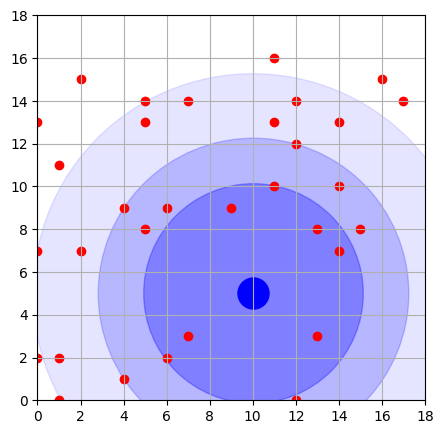

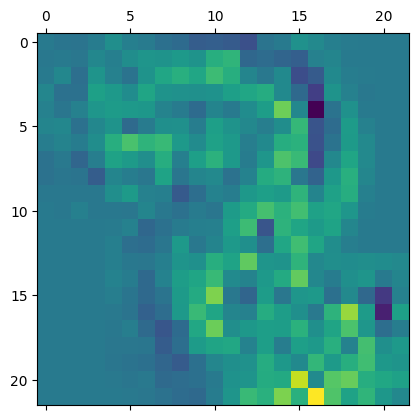

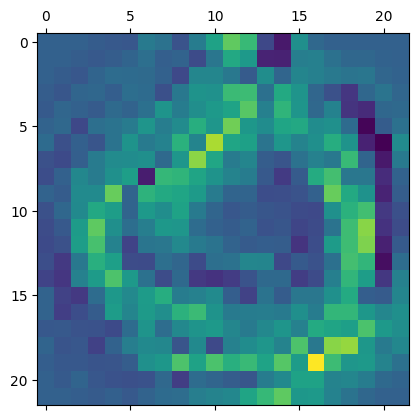

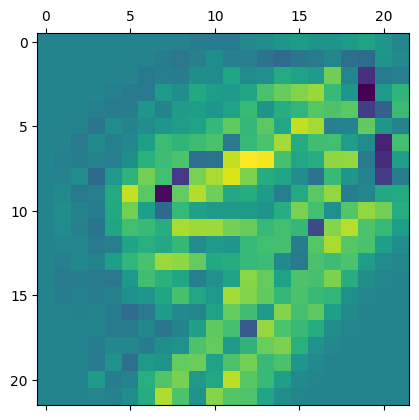

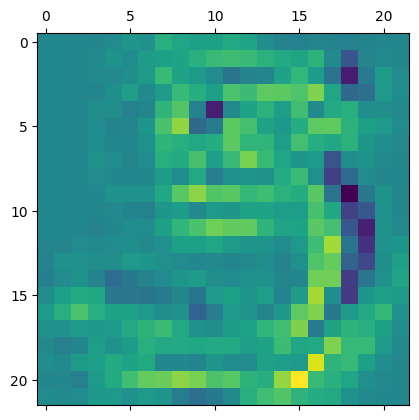

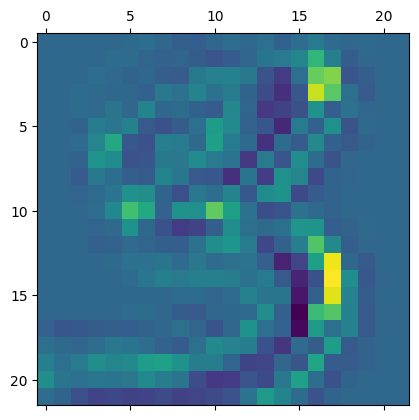

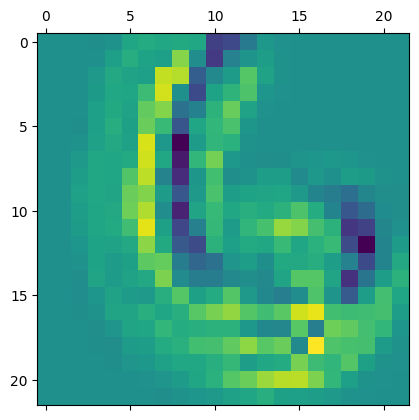

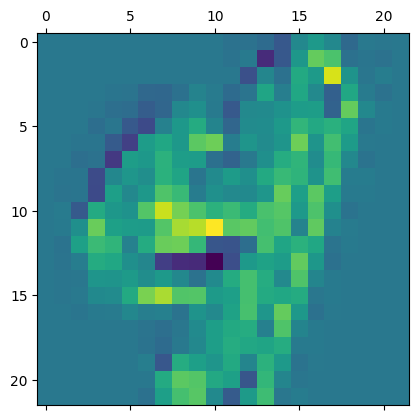

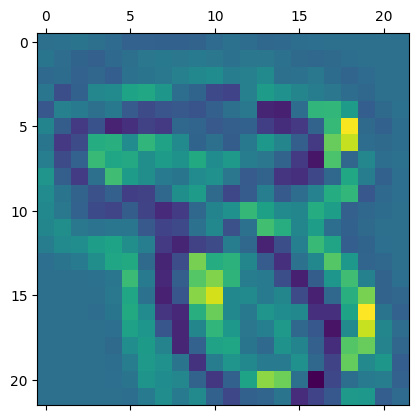

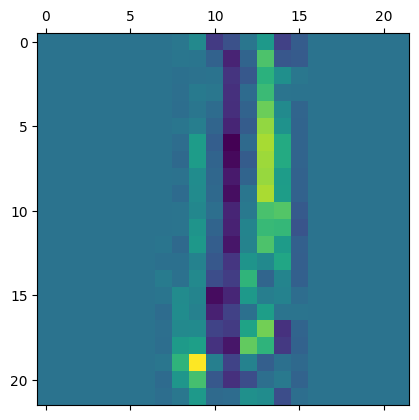

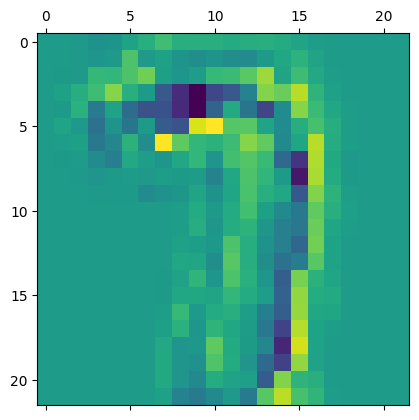

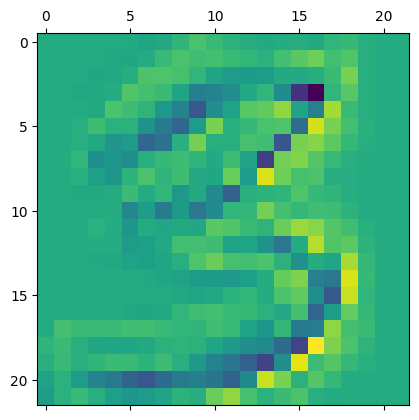

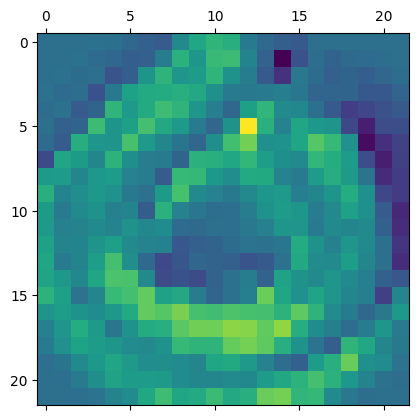

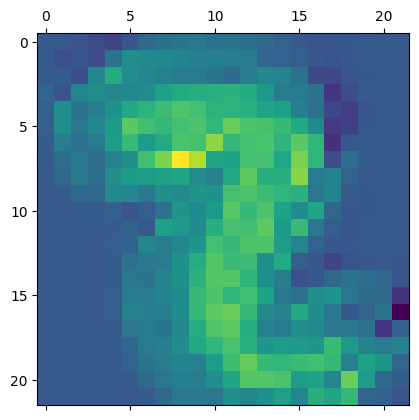

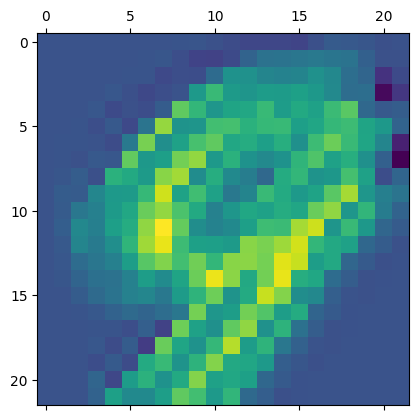

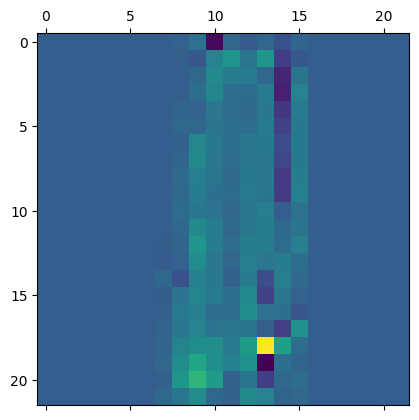

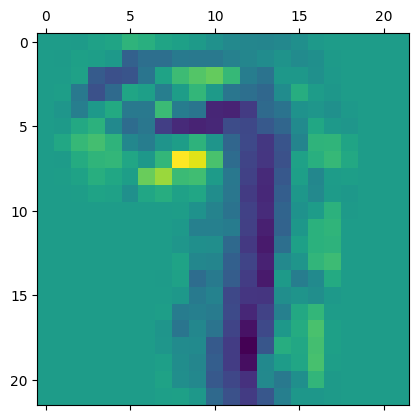

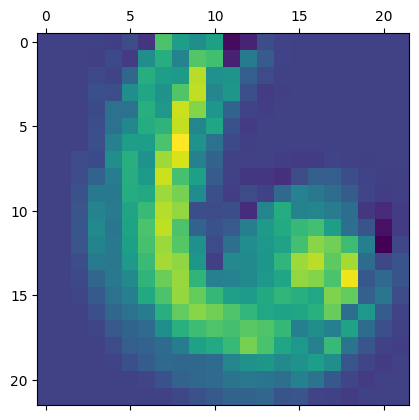

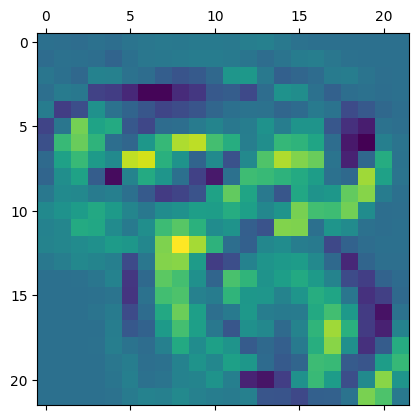

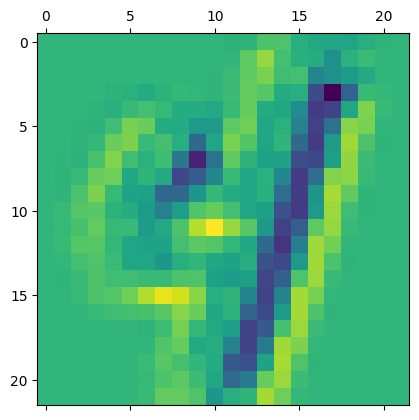

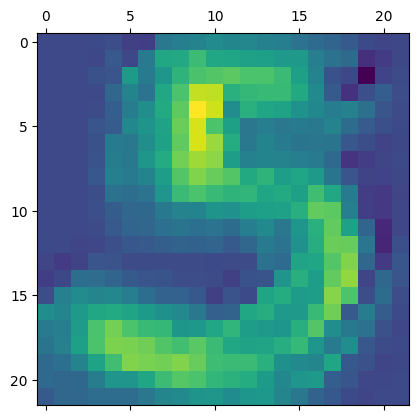

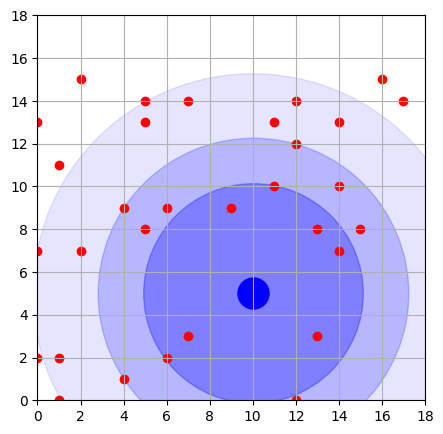

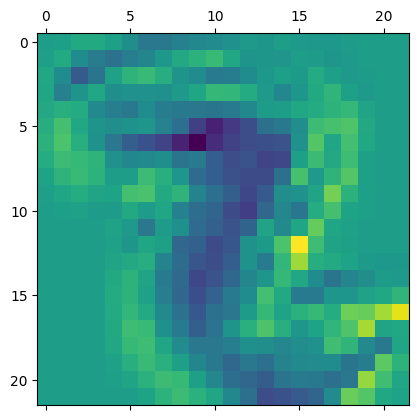

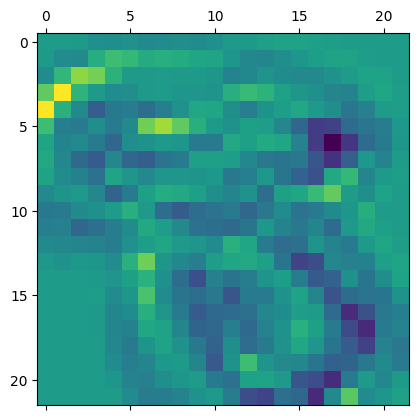

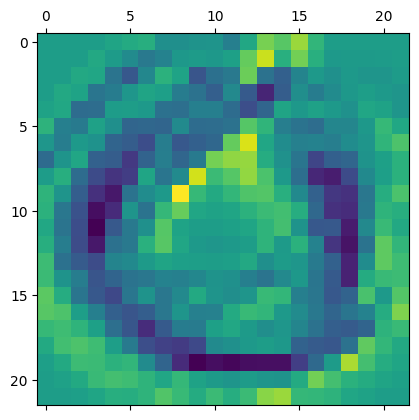

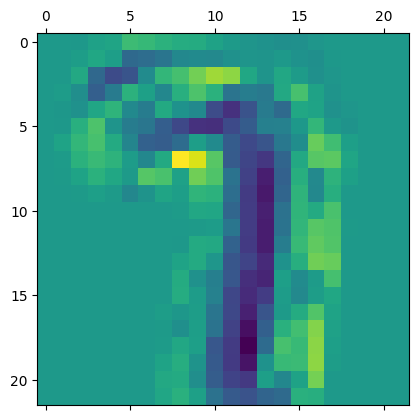

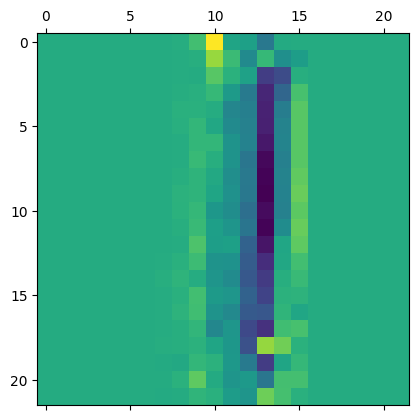

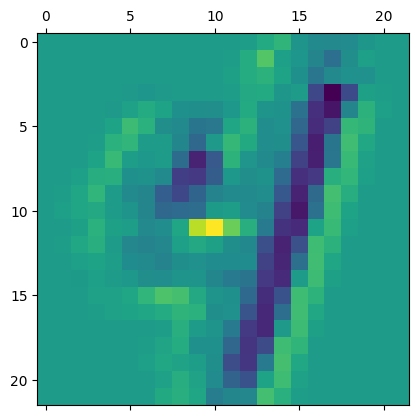

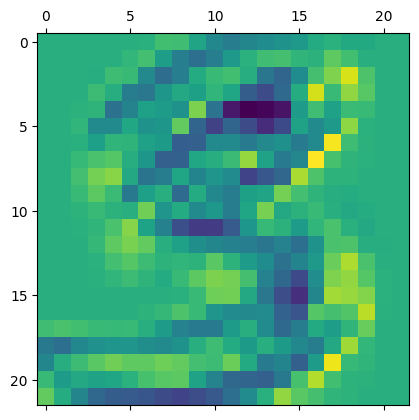

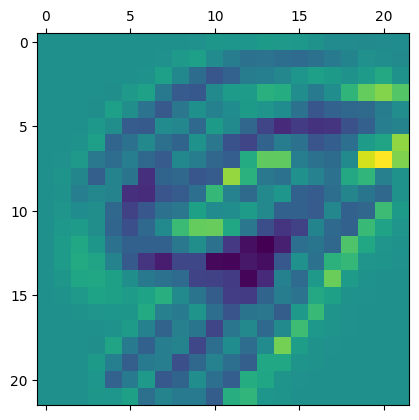

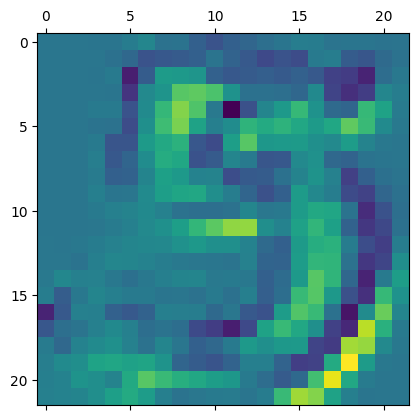

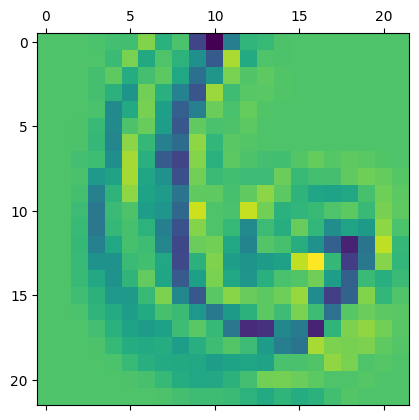

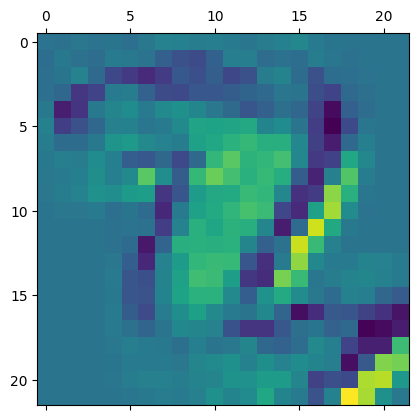

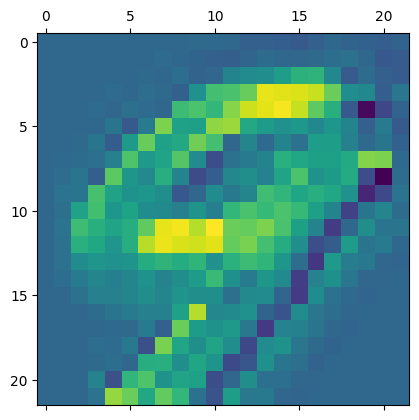

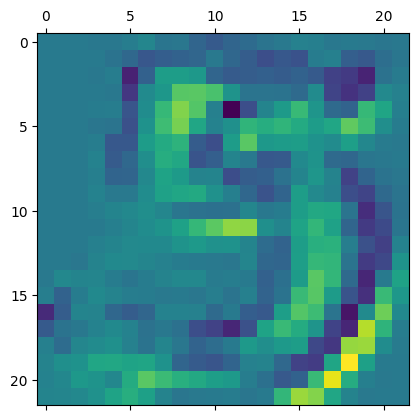

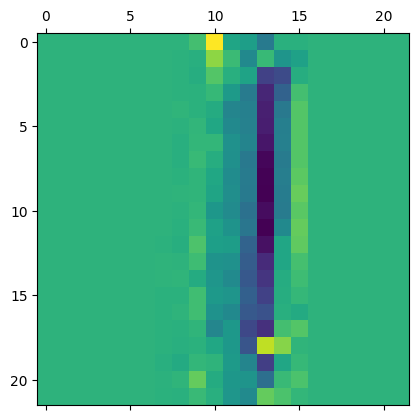

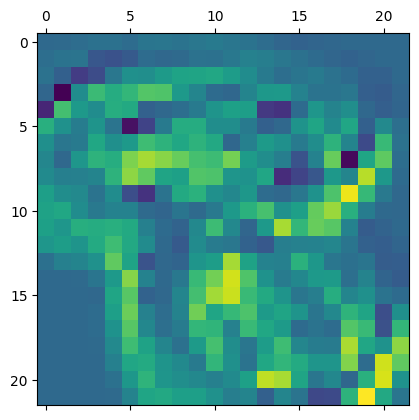

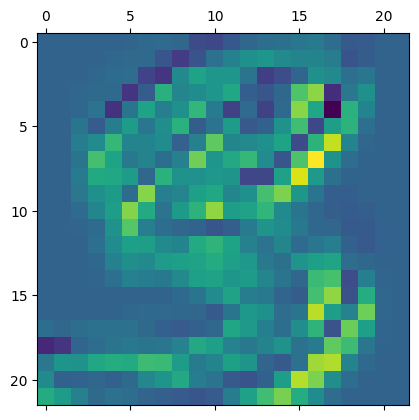

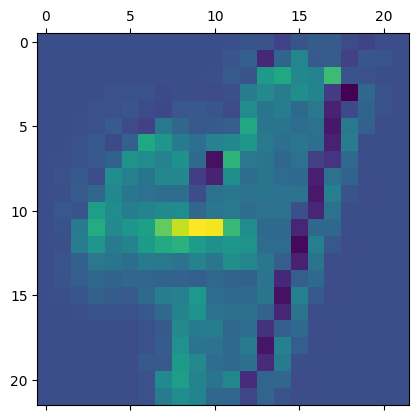

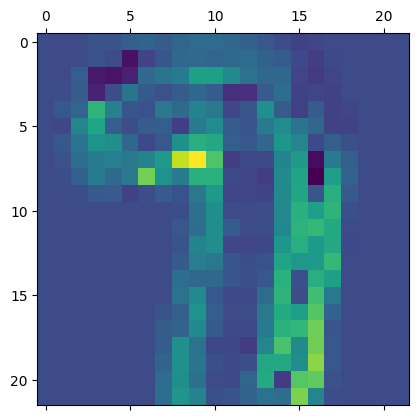

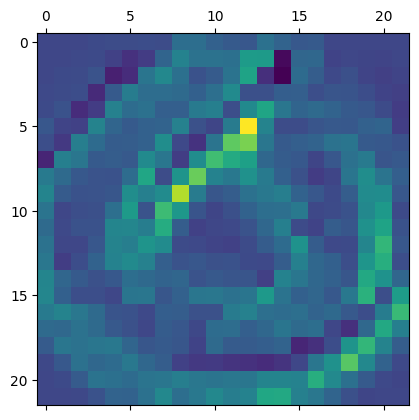

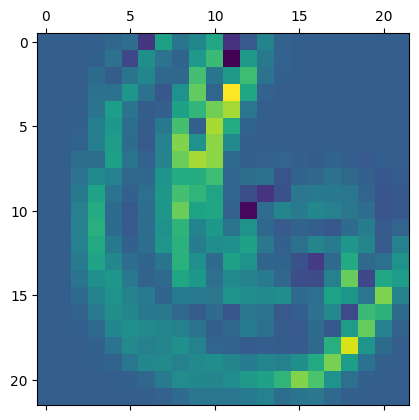

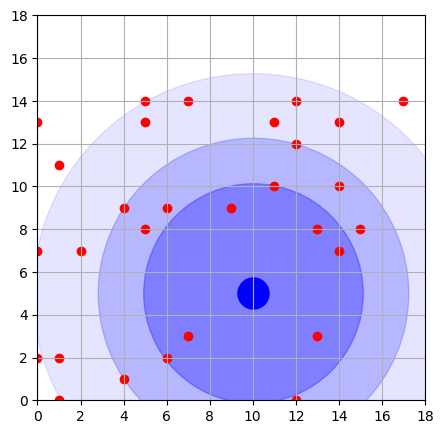

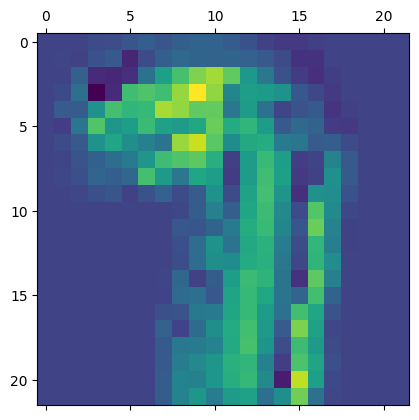

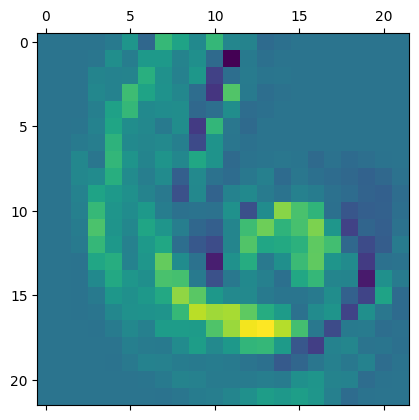

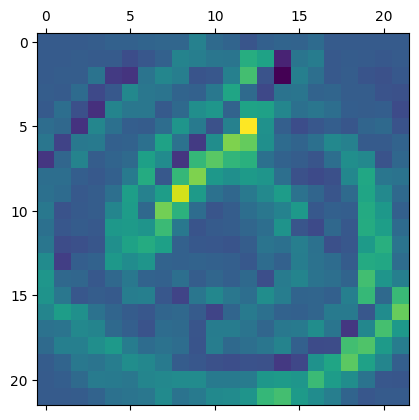

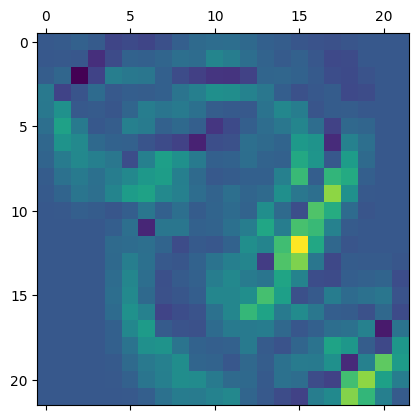

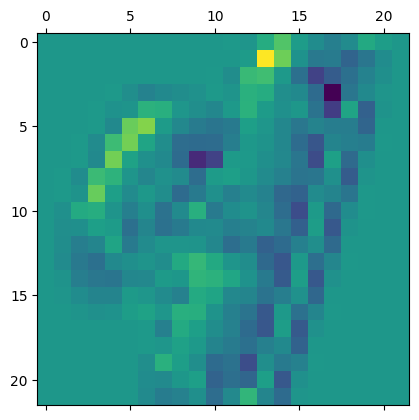

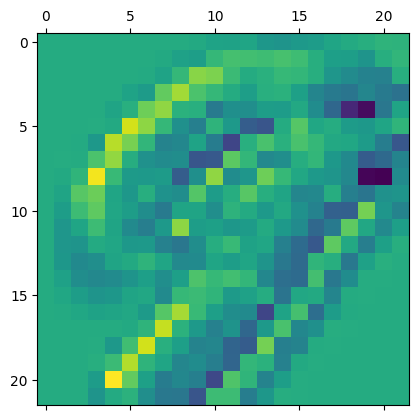

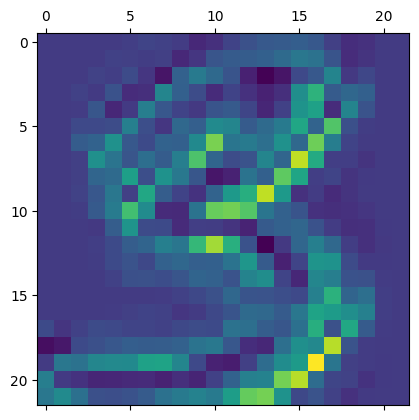

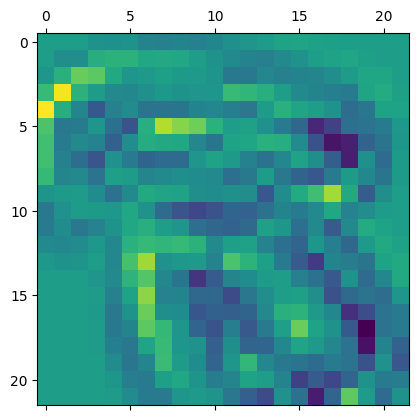

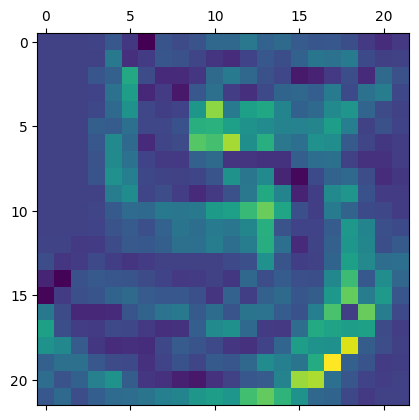

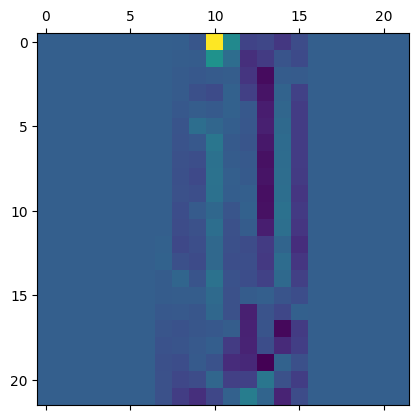

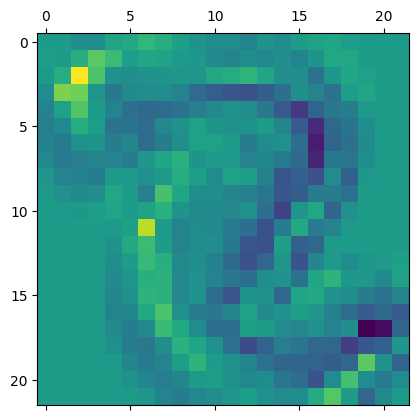

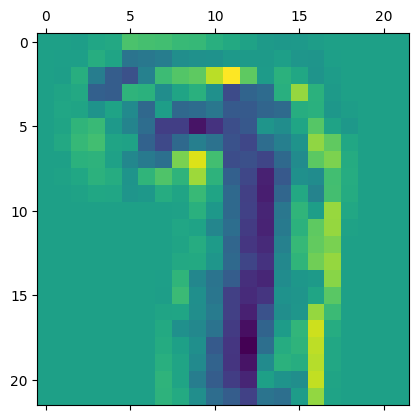

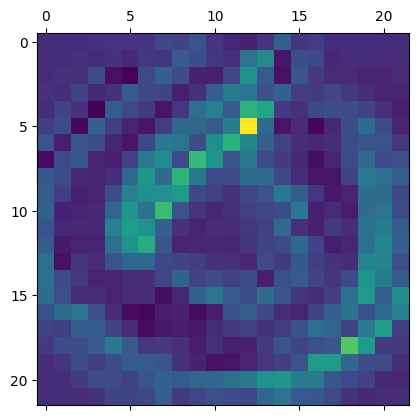

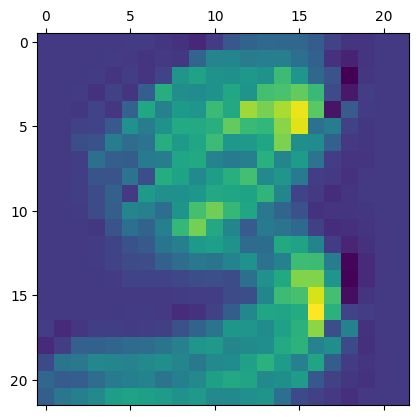

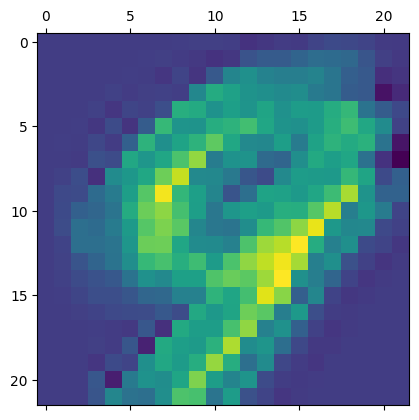

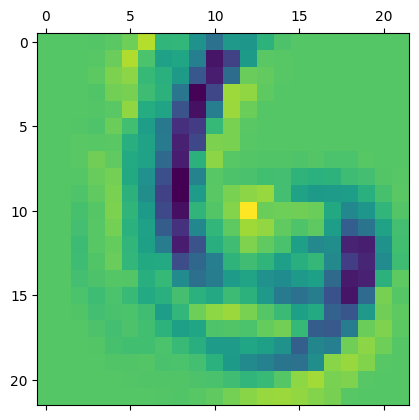

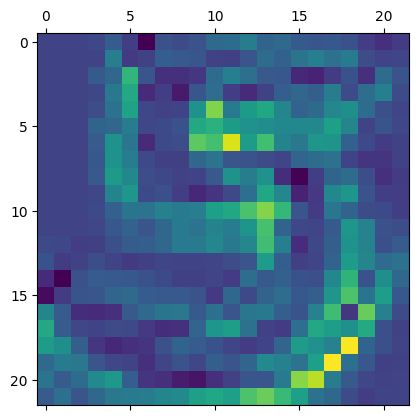

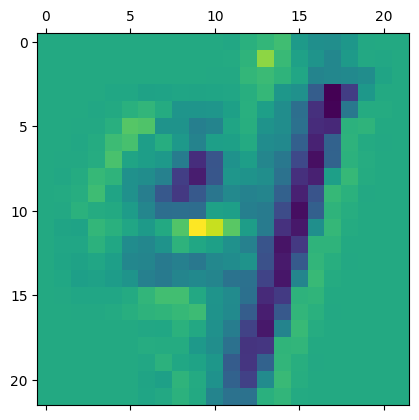

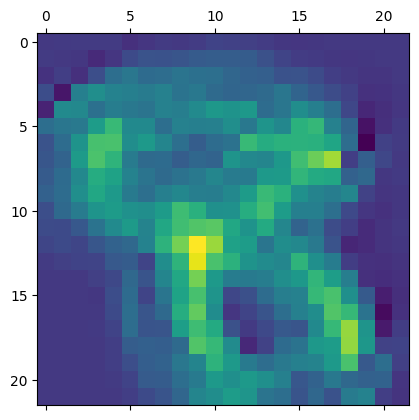

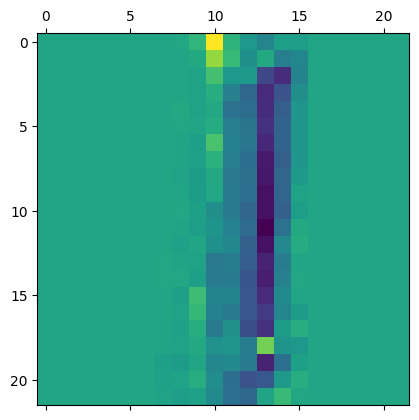

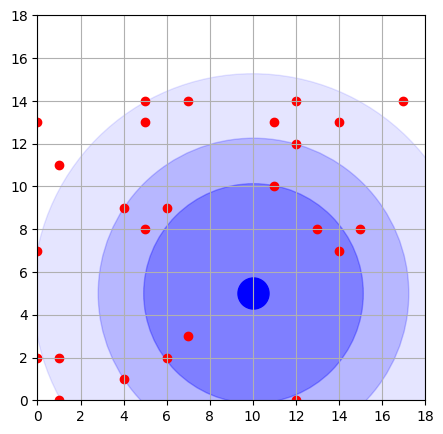

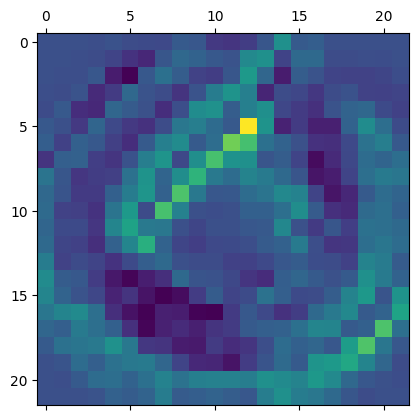

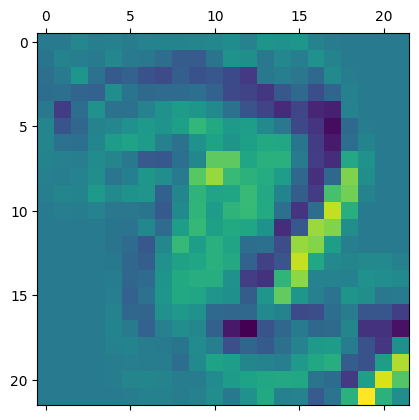

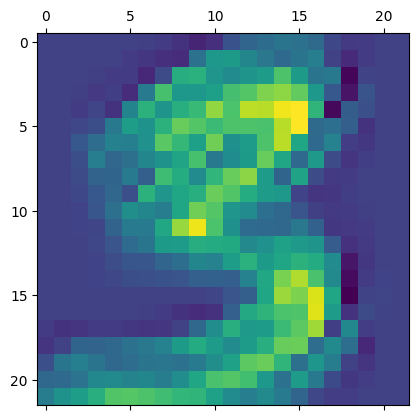

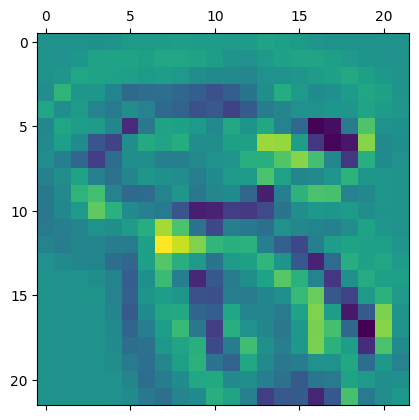

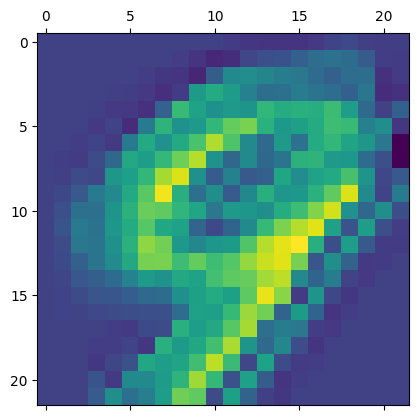

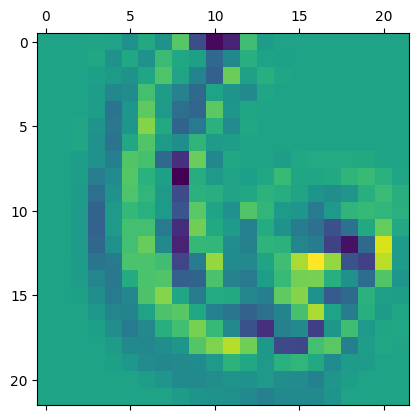

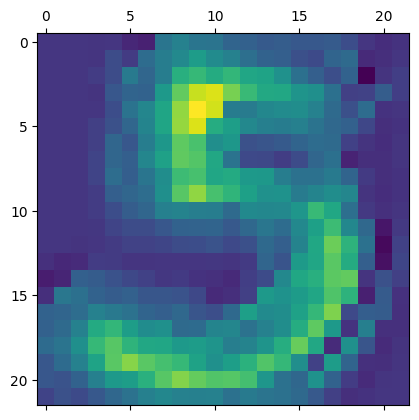

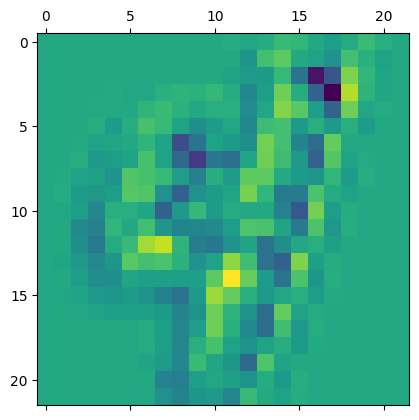

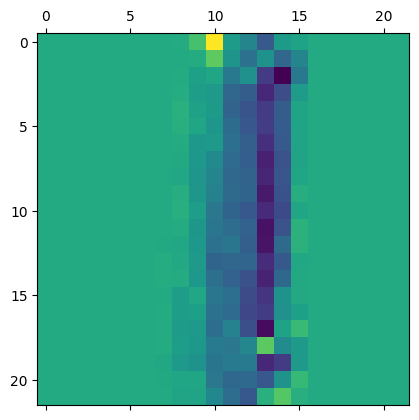

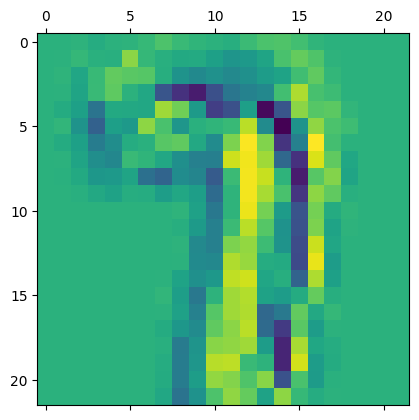

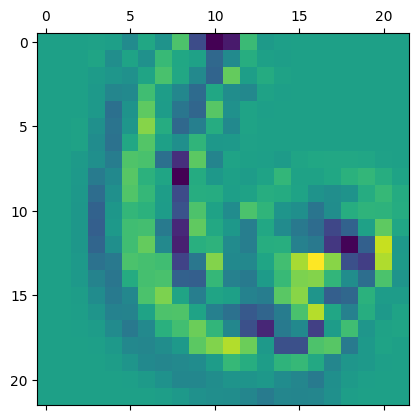

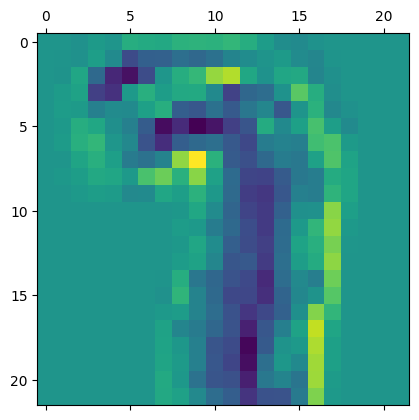

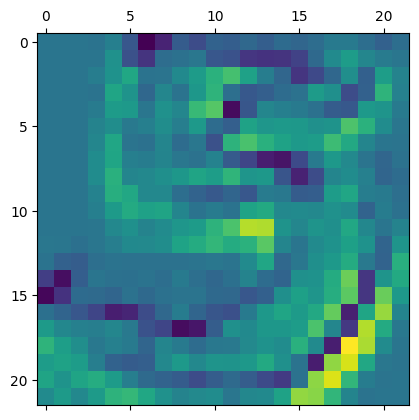

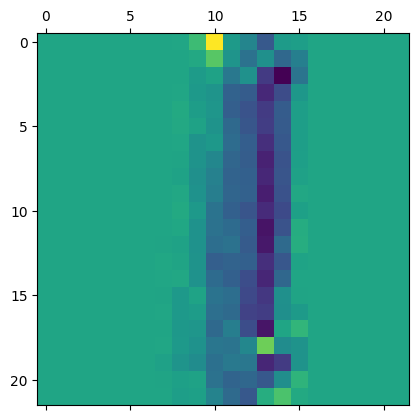

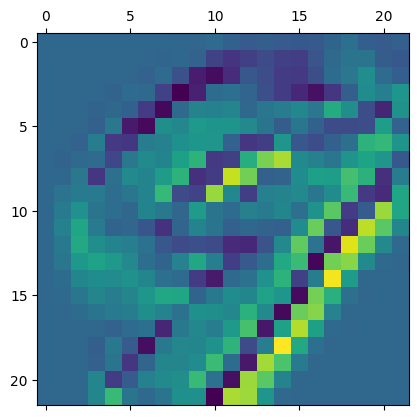

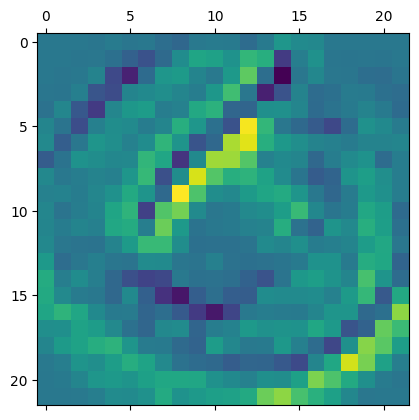

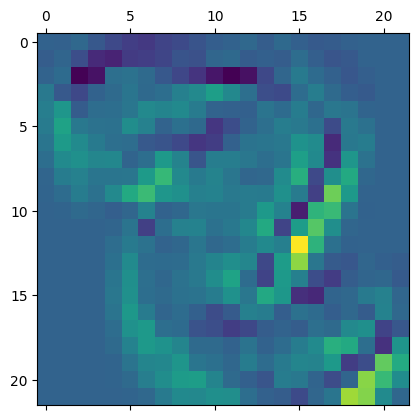

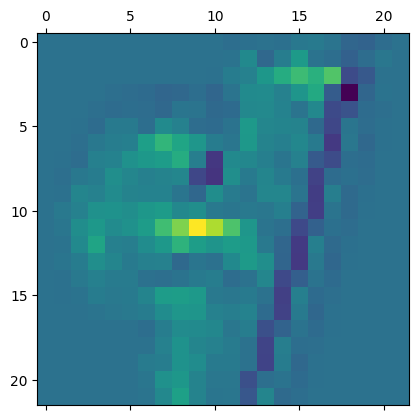

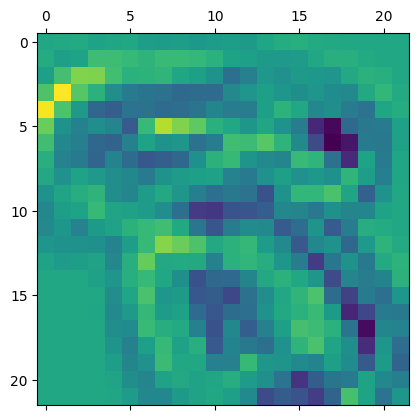

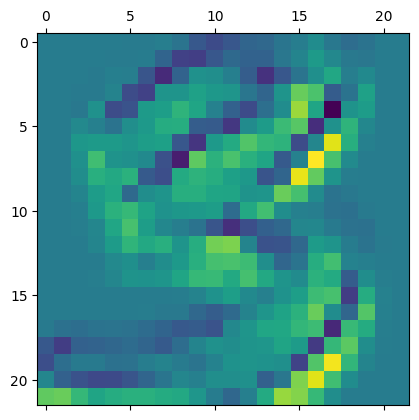

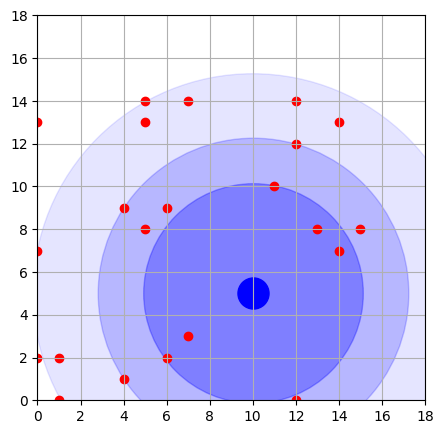

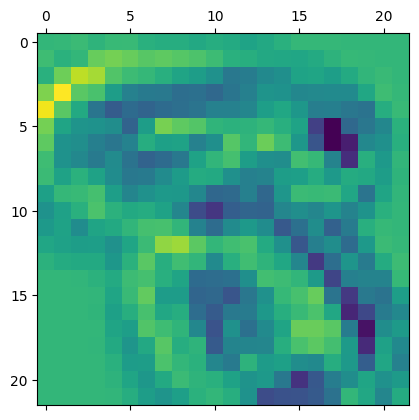

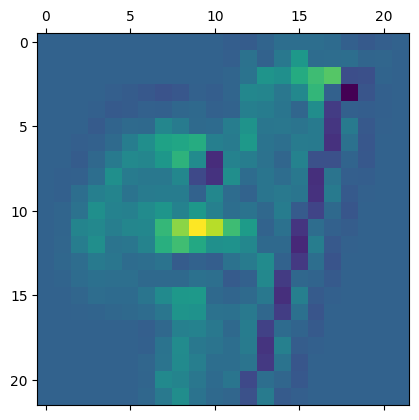

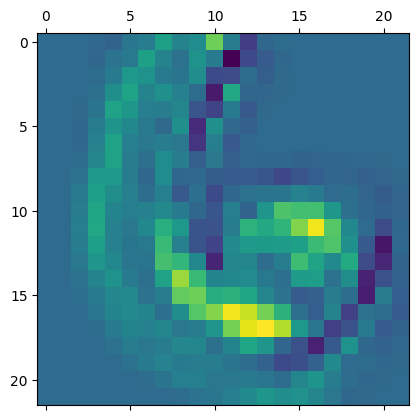

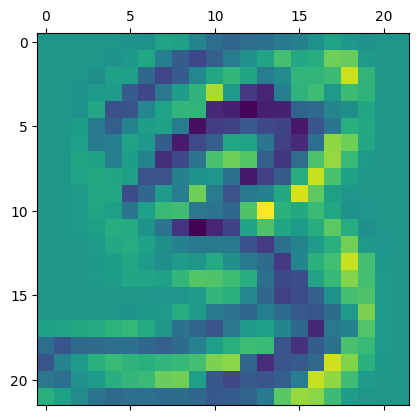

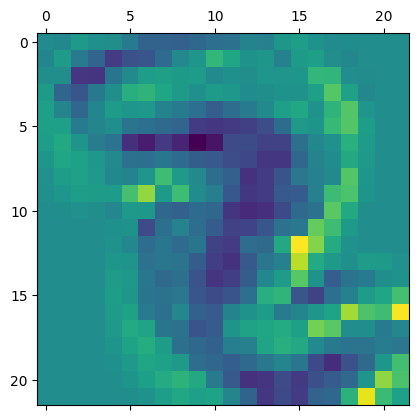

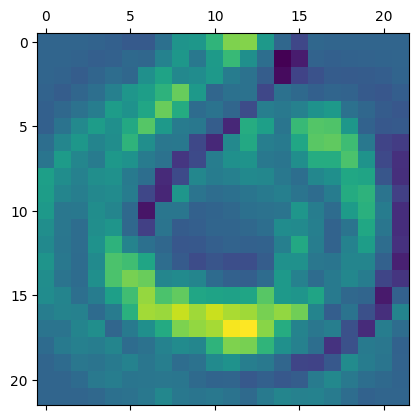

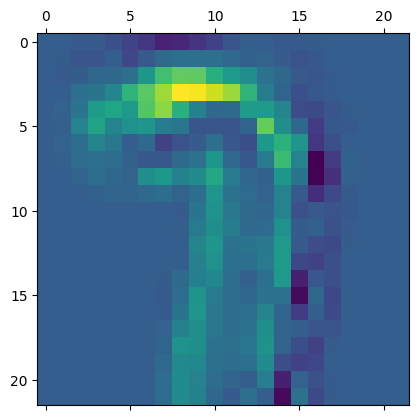

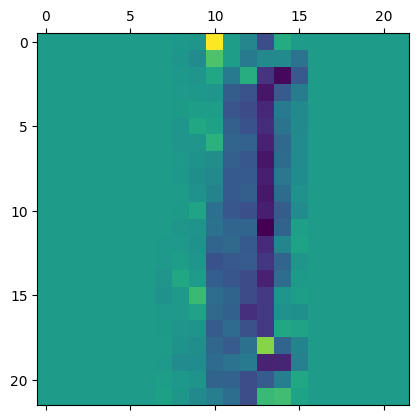

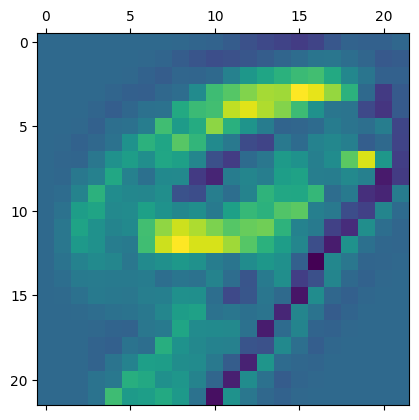

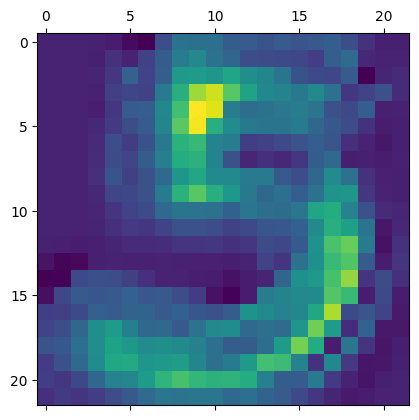

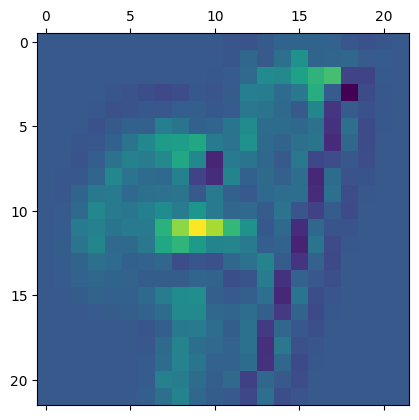

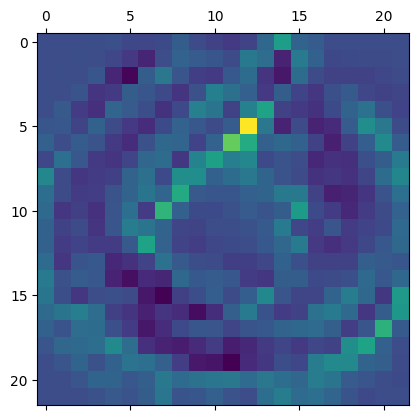

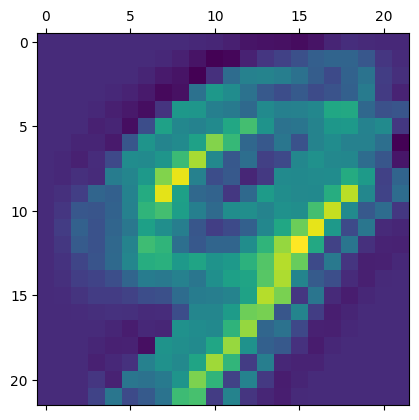

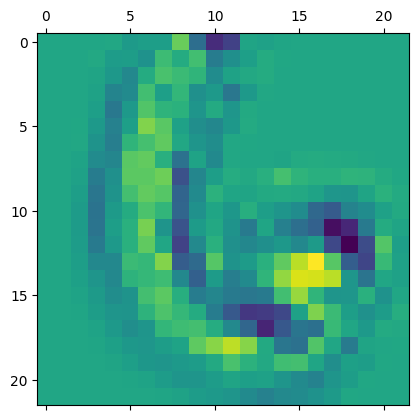

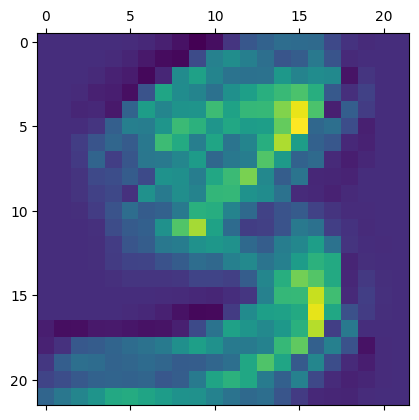

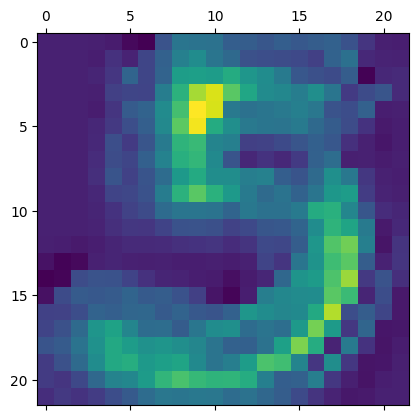

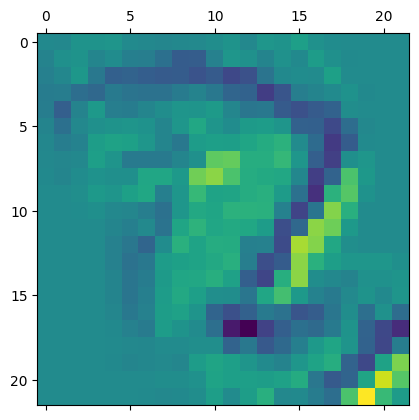

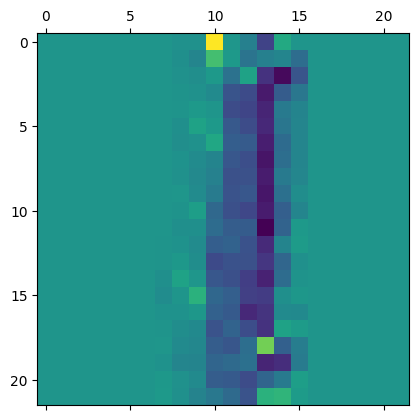

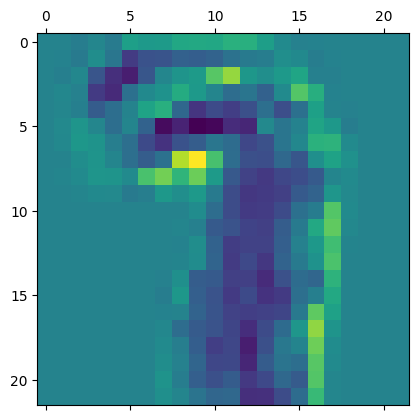

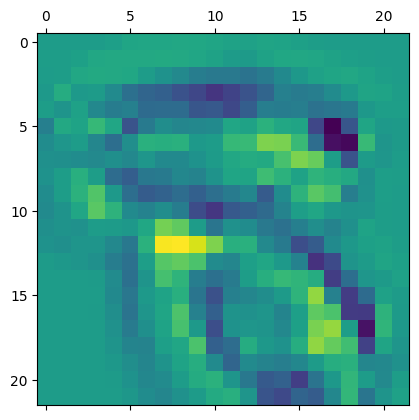

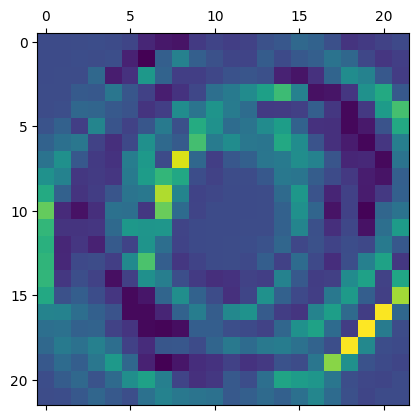

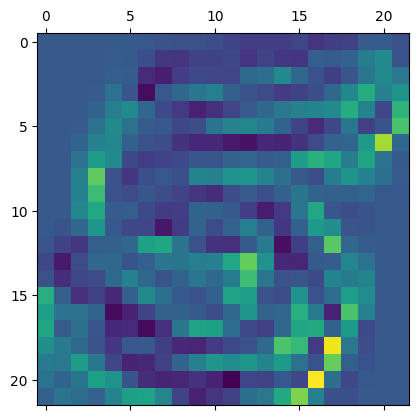

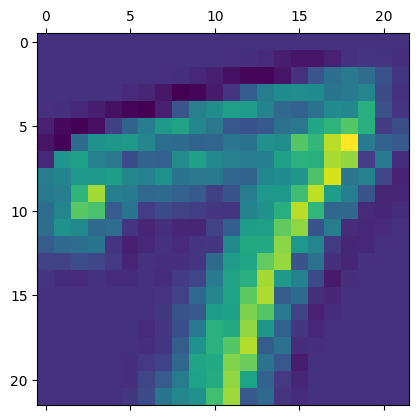

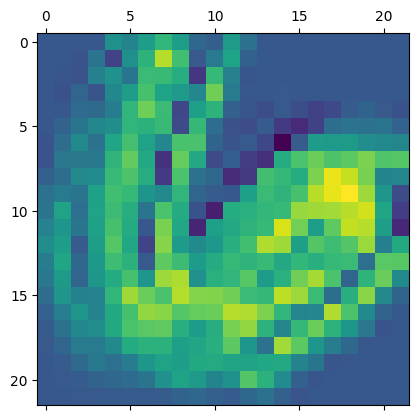

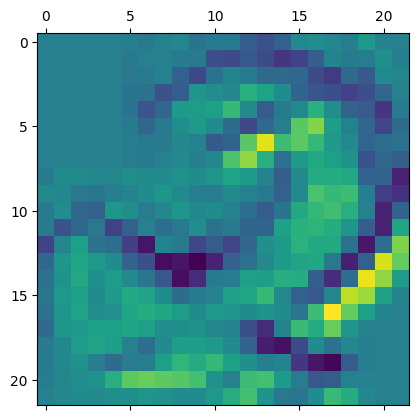

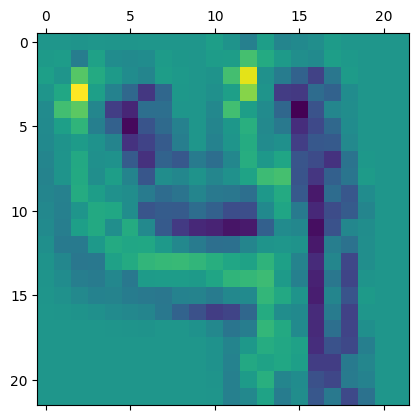

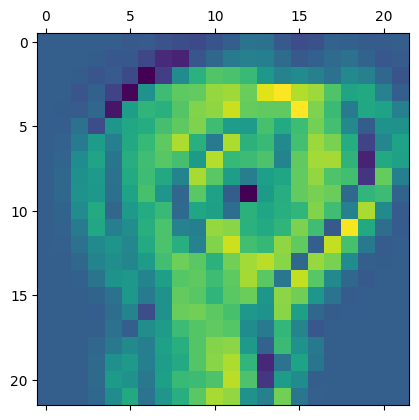

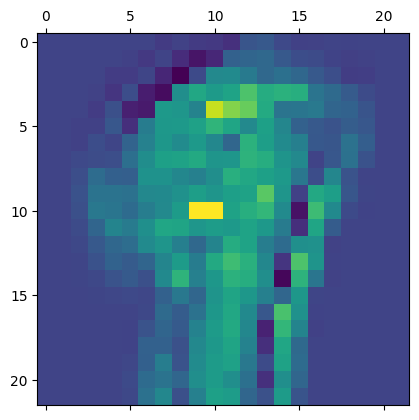

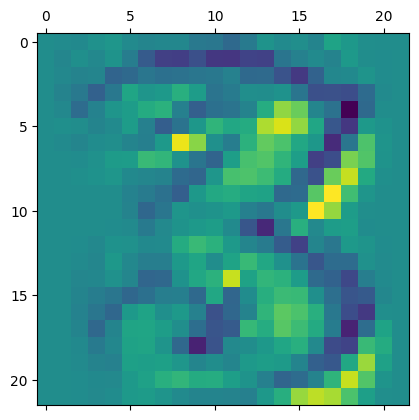

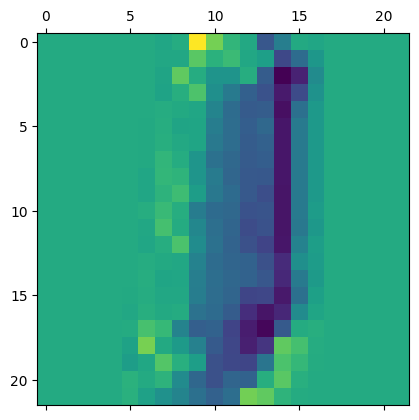

In [21]:
model, results, v_res = dev_routine(model_kwargs={
                                'n_classes': 10,
                                'out_dim' :  [1, 8, 16, 32], # [1, 8, 16, 32], #[1, 16, 24, 32]
                                'grid_size' : 18*18,
                                'criterion': torch.nn.CrossEntropyLoss(),# torch.nn.BCEWithLogitsLoss(),
                                'optimizer': "sgd", # sgd adamw
                                'base_lr': 0.001,
                                'min_lr' : 0.00001,
                                'momentum' : 0.9,
                                'lr_update' : 100,
                                'cc_weight': 10,
                                'cc_metric' : 'l2',
                                'update_every_nth_epoch' : 2, # 10
                                'prune_keep' : 0.9, # 0.97, # in each epoch
                                'prune_keep_total' : 0.5, # this number is not exact, depends on the prune_keep value
                            },
                            train_kwargs={
                                'ckpt_path': "example_results/lightning_logs", # "example_results/lightning_logs", # not in use??
                                'exp_name': "tmp",
                                'load_ckpt_file' : "xversion_22/checkpoints/epoch=0-unpruned=10942-val_f1=0.06.ckpt", # 'version_94/checkpoints/epoch=26-step=1080.ckpt', # change this for loading a file and using "test", if you want training, keep None
                                'epochs': 10,
                                'img_size' : 28, #168, # keep mnist at original size, training didn't work when i increased the size ...
                                'batch_size': 1, # 128, # the higher the batch_size the faster the training - every iteration adds A LOT OF comp cost
                                'log_every_n_steps' : 4, # lightning default: 50 # needs to be bigger than the amount of steps in an epoch (based on trainset size and batchsize)
                                # 'test_batch_size': 1,
                                'device': "cuda",
                                'num_workers' : 0, # 18, # 18 for computer, 0 for laptop
                            }
                            )


In [25]:
torch.__version__

'2.0.0'

In [26]:
pl.__version__

'2.1.0'

In [22]:
model

DecentLightning(
  (model): DecentNet(
    (decent1): DecentLayer(
      (filter_list): ModuleList(
        (0): DecentFilter(weights: torch.Size([1, 1, 3, 3]) at position: m_this=Parameter containing:
        tensor([10.], device='cuda:0'), n_this=Parameter containing:
        tensor([10.], device='cuda:0'))
         with inputs: ms_in= 0, ns_in= 0)
        (1): DecentFilter(weights: torch.Size([1, 1, 3, 3]) at position: m_this=Parameter containing:
        tensor([1.], device='cuda:0'), n_this=Parameter containing:
        tensor([6.], device='cuda:0'))
         with inputs: ms_in= 0, ns_in= 0)
        (2): DecentFilter(weights: torch.Size([1, 1, 3, 3]) at position: m_this=Parameter containing:
        tensor([2.], device='cuda:0'), n_this=Parameter containing:
        tensor([1.], device='cuda:0'))
         with inputs: ms_in= 0, ns_in= 0)
        (3): DecentFilter(weights: torch.Size([1, 1, 3, 3]) at position: m_this=Parameter containing:
        tensor([13.], device='cuda:0'), n_t

torch.Size([1, 3, 28, 28])

Layer: DecentFilter(weights: torch.Size([1, 8, 3, 3]) at position: m_this=Parameter containing:
tensor([10.]), n_this=Parameter containing:
tensor([5.]))
 with inputs: ms_in= 10, 1, 2, 13, 14, 12, 2, 8, ns_in= 10, 6, 1, 11, 1, 2, 3, 15)

Epoch 0:   0%|                                                                                  | 0/10 [14:24<?, ?it/s]
amount of feature maps: 24


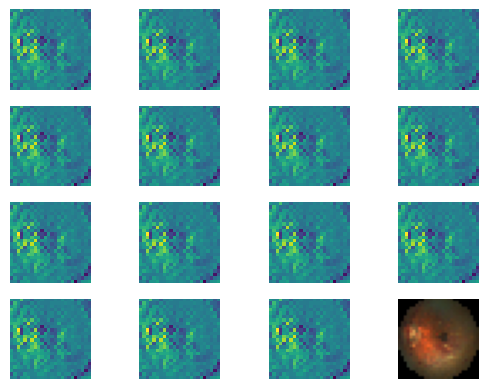

torch.Size([1, 3, 28, 28])

Layer: DecentFilter(weights: torch.Size([1, 8, 3, 3]) at position: m_this=Parameter containing:
tensor([13.]), n_this=Parameter containing:
tensor([0.]))
 with inputs: ms_in= 10, 1, 2, 13, 14, 12, 2, 8, ns_in= 10, 6, 1, 11, 1, 2, 3, 15)

amount of feature maps: 24


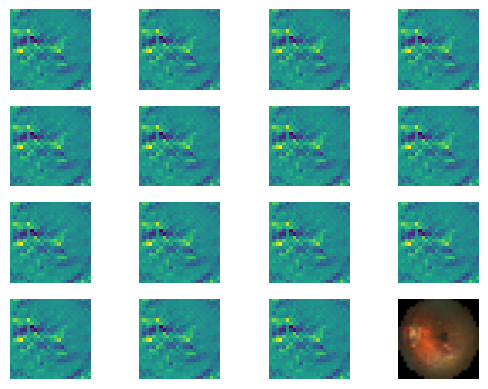

torch.Size([1, 3, 28, 28])

Layer: DecentFilter(weights: torch.Size([1, 8, 3, 3]) at position: m_this=Parameter containing:
tensor([13.]), n_this=Parameter containing:
tensor([6.]))
 with inputs: ms_in= 10, 1, 2, 13, 14, 12, 2, 8, ns_in= 10, 6, 1, 11, 1, 2, 3, 15)

amount of feature maps: 24


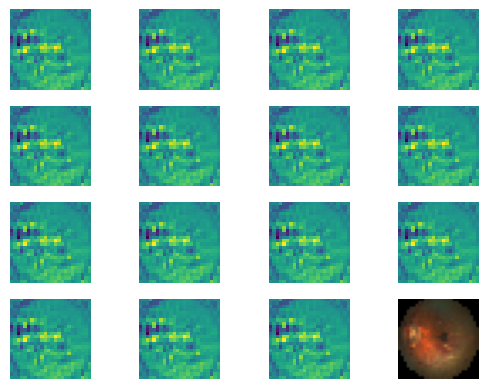

torch.Size([1, 3, 28, 28])

Layer: DecentFilter(weights: torch.Size([1, 8, 3, 3]) at position: m_this=Parameter containing:
tensor([9.]), n_this=Parameter containing:
tensor([7.]))
 with inputs: ms_in= 10, 1, 2, 13, 14, 12, 2, 8, ns_in= 10, 6, 1, 11, 1, 2, 3, 15)

amount of feature maps: 24


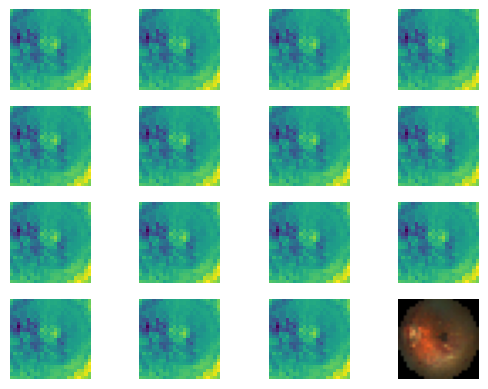

torch.Size([1, 3, 28, 28])

Layer: DecentFilter(weights: torch.Size([1, 8, 3, 3]) at position: m_this=Parameter containing:
tensor([0.]), n_this=Parameter containing:
tensor([16.]))
 with inputs: ms_in= 10, 1, 2, 13, 14, 12, 2, 8, ns_in= 10, 6, 1, 11, 1, 2, 3, 15)

amount of feature maps: 24


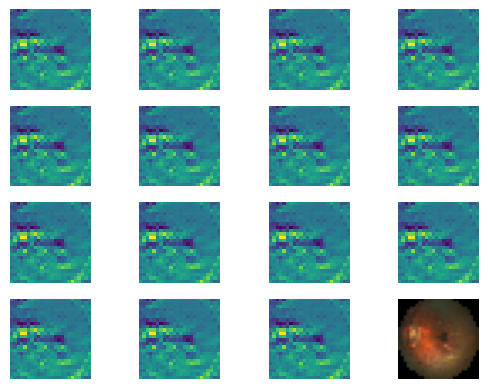

torch.Size([1, 3, 28, 28])

Layer: DecentFilter(weights: torch.Size([1, 8, 3, 3]) at position: m_this=Parameter containing:
tensor([12.]), n_this=Parameter containing:
tensor([6.]))
 with inputs: ms_in= 10, 1, 2, 13, 14, 12, 2, 8, ns_in= 10, 6, 1, 11, 1, 2, 3, 15)

amount of feature maps: 24


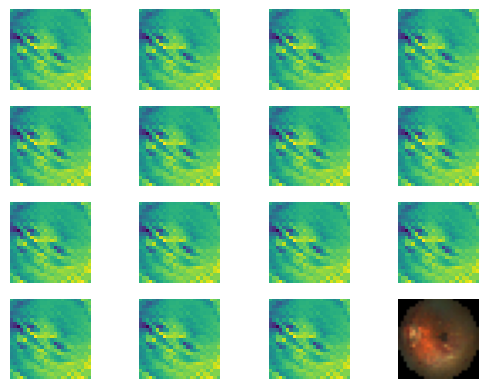

torch.Size([1, 3, 28, 28])

Layer: DecentFilter(weights: torch.Size([1, 8, 3, 3]) at position: m_this=Parameter containing:
tensor([14.]), n_this=Parameter containing:
tensor([16.]))
 with inputs: ms_in= 10, 1, 2, 13, 14, 12, 2, 8, ns_in= 10, 6, 1, 11, 1, 2, 3, 15)

amount of feature maps: 24


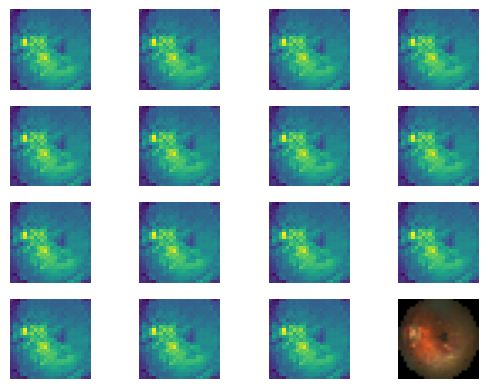

torch.Size([1, 3, 28, 28])

Layer: DecentFilter(weights: torch.Size([1, 8, 3, 3]) at position: m_this=Parameter containing:
tensor([7.]), n_this=Parameter containing:
tensor([8.]))
 with inputs: ms_in= 10, 1, 2, 13, 14, 12, 2, 8, ns_in= 10, 6, 1, 11, 1, 2, 3, 15)

amount of feature maps: 24


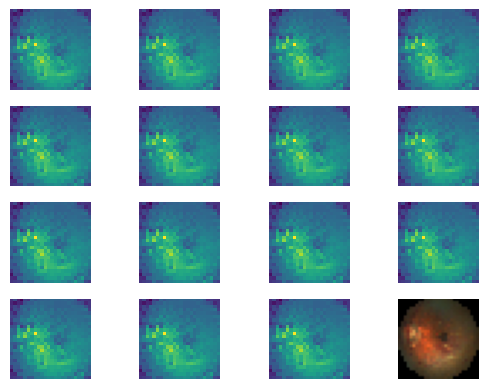

torch.Size([1, 3, 28, 28])

Layer: DecentFilter(weights: torch.Size([1, 8, 3, 3]) at position: m_this=Parameter containing:
tensor([16.]), n_this=Parameter containing:
tensor([3.]))
 with inputs: ms_in= 10, 1, 2, 13, 14, 12, 2, 8, ns_in= 10, 6, 1, 11, 1, 2, 3, 15)

amount of feature maps: 24


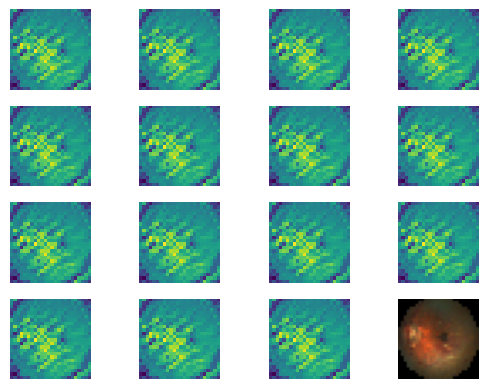

torch.Size([1, 3, 28, 28])

Layer: DecentFilter(weights: torch.Size([1, 8, 3, 3]) at position: m_this=Parameter containing:
tensor([3.]), n_this=Parameter containing:
tensor([3.]))
 with inputs: ms_in= 10, 1, 2, 13, 14, 12, 2, 8, ns_in= 10, 6, 1, 11, 1, 2, 3, 15)

amount of feature maps: 24


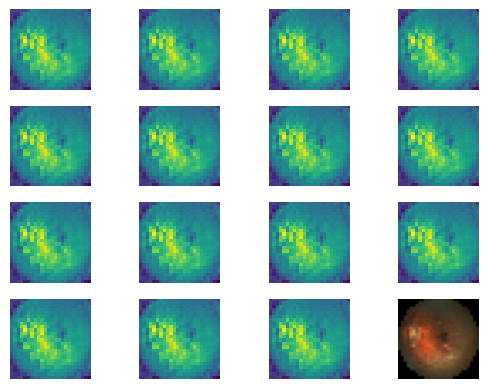

torch.Size([1, 3, 28, 28])

Layer: DecentFilter(weights: torch.Size([1, 8, 3, 3]) at position: m_this=Parameter containing:
tensor([7.]), n_this=Parameter containing:
tensor([7.]))
 with inputs: ms_in= 10, 1, 2, 13, 14, 12, 2, 8, ns_in= 10, 6, 1, 11, 1, 2, 3, 15)

amount of feature maps: 24


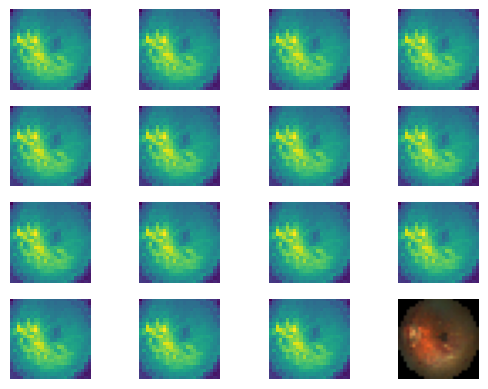

torch.Size([1, 3, 28, 28])

Layer: DecentFilter(weights: torch.Size([1, 8, 3, 3]) at position: m_this=Parameter containing:
tensor([9.]), n_this=Parameter containing:
tensor([13.]))
 with inputs: ms_in= 10, 1, 2, 13, 14, 12, 2, 8, ns_in= 10, 6, 1, 11, 1, 2, 3, 15)

amount of feature maps: 24


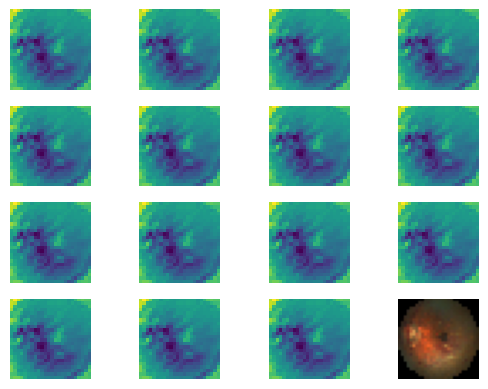

torch.Size([1, 3, 28, 28])

Layer: DecentFilter(weights: torch.Size([1, 8, 3, 3]) at position: m_this=Parameter containing:
tensor([9.]), n_this=Parameter containing:
tensor([10.]))
 with inputs: ms_in= 10, 1, 2, 13, 14, 12, 2, 8, ns_in= 10, 6, 1, 11, 1, 2, 3, 15)

amount of feature maps: 24


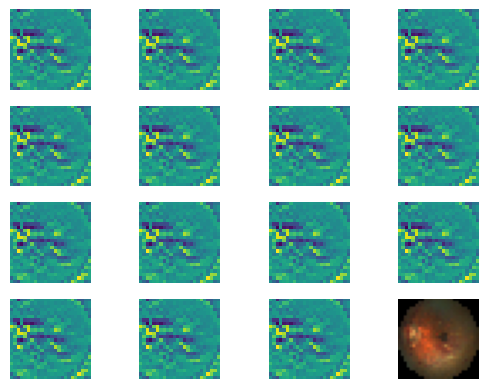

torch.Size([1, 3, 28, 28])

Layer: DecentFilter(weights: torch.Size([1, 8, 3, 3]) at position: m_this=Parameter containing:
tensor([16.]), n_this=Parameter containing:
tensor([14.]))
 with inputs: ms_in= 10, 1, 2, 13, 14, 12, 2, 8, ns_in= 10, 6, 1, 11, 1, 2, 3, 15)

amount of feature maps: 24


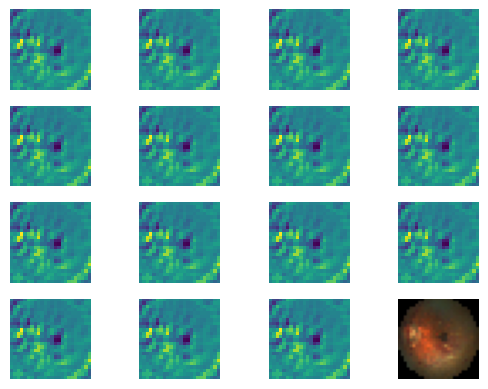

torch.Size([1, 3, 28, 28])

Layer: DecentFilter(weights: torch.Size([1, 8, 3, 3]) at position: m_this=Parameter containing:
tensor([6.]), n_this=Parameter containing:
tensor([8.]))
 with inputs: ms_in= 10, 1, 2, 13, 14, 12, 2, 8, ns_in= 10, 6, 1, 11, 1, 2, 3, 15)

amount of feature maps: 24


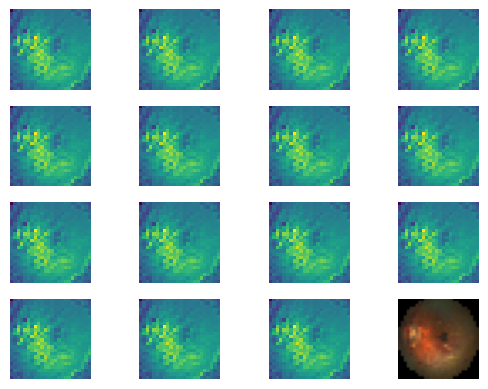

torch.Size([1, 3, 28, 28])

Layer: DecentFilter(weights: torch.Size([1, 8, 3, 3]) at position: m_this=Parameter containing:
tensor([11.]), n_this=Parameter containing:
tensor([10.]))
 with inputs: ms_in= 10, 1, 2, 13, 14, 12, 2, 8, ns_in= 10, 6, 1, 11, 1, 2, 3, 15)

amount of feature maps: 24


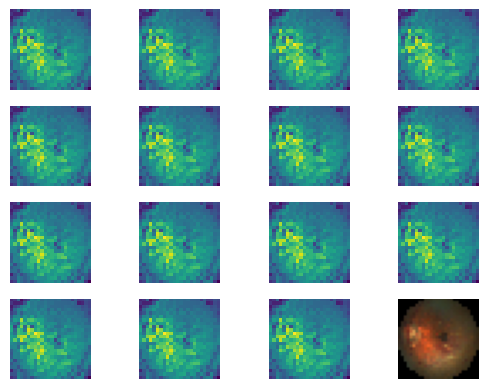

In [161]:
import torchvision

for l in range(100):
    try:
        layer = model.model.decent2.filter_list[l] # .filter_list[7]weights
        run_explain(model, layer, device='cuda')
    except:
        pass

In [ ]:
import torchvision
layer = model.model.decent2 # .filter_list[7]weights
run_explain(model, layer, device='cuda')

In [ ]:
results

In [ ]:
v_res

In [ ]:
torch.load("example_results/lightning_logs/tmp/version_22/checkpoints/epoch=4-unpruned=10815-val_f1=0.12.ckpt").keys()

In [ ]:
torch.load("example_results/lightning_logs/tmp/version_22/checkpoints/epoch=4-unpruned=10815-val_f1=0.12.ckpt")['loops'].keys()

In [ ]:
torch.load("example_results/lightning_logs/tmp/version_22/checkpoints/epoch=4-unpruned=10815-val_f1=0.12.ckpt")['state_dict'].keys()

In [ ]:
model

### normal train without lightning

In [ ]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for i_batch, (data, target) in enumerate(train_loader):
        
        
        data, target = data.to(device), target.unsqueeze(1) # .to(device)
        optimizer.zero_grad()
        output = model(data)
        
        
        target_multi_hot = torch.zeros(target.size(0), 10).scatter_(1, target, 1.).to(device)
        
        if i_batch == 5:
            
            
            #model.update()
            
            #print(data.shape) # torch.Size([4, 1, 28, 28])
            #print(target)
            """
            tensor([[8],
            [7],
            [2],
            [7]])
            """
            #print(target_multi_hot)
            """
            tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
            [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
            [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
            [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], device='cuda:0')
            """
            pass
        
        
        loss = F.binary_cross_entropy(output, target_multi_hot)
        loss.backward()
        optimizer.step()
        if i_batch % (args.log_interval*1000) == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i_batch * len(data), len(train_loader.dataset),
                100. * i_batch / len(train_loader), loss.item()))
            
            # model.update()

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.unsqueeze(1) # .to(device)
            
            output = model(data)
            
            target_multi_hot = torch.zeros(target.size(0), 10).scatter_(1, target, 1.).to(device)
            test_loss += F.binary_cross_entropy(output, target_multi_hot, reduction='mean').item()
        
            # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.to(device).view_as(pred)).sum().item()
            
            if False: # i == 0:
                print(data.shape)
                layer = model.conv1x1 # model.conv1[0] # model.stage2[0].branch1[2] # model.fusion_layer # conv
                # run feature map
                dd = FeatureMap(model=model, layer=layer, device=device, iterations=None, lr=None)
                dd.run(data)
                dd.plot()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

class Parser():
    def __init__(self):
        self.batch_size = 16
        self.test_batch_size = 1
        self.epochs = 100
        self.lr = 0.001
        self.gamma = 0.7
        self.log_interval = 1
        self.save_model = False
        

def main():
    # Training settings
    args = Parser()
    
    if True:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if device == torch.device("cuda"):
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('example_data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('example_data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = DecentNet().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()
        
        model.update() 

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.ckpt")

    return model

if False:
    model = main()

    for i in model.parameters():
        print(i.shape)
    

# conv filter test

In [ ]:
import torch
import torch.nn.functional as F

# this is one filter

w_groups = 1 # groups of the channels
w_channels = 1024 # input channels
w_filters = 10

assert w_filters % w_groups == 0
assert w_channels % w_groups == 0

# batch size x channels (= w_groups*w_channels) x width x height
inputs = torch.autograd.Variable(torch.randn(27,w_groups*w_channels,100,100))

# w_filters x w_channels x kernel x kernel
weights = torch.autograd.Variable(torch.randn(w_filters,w_channels,3,3))

# batch size x w_filters x width x height
out = F.conv2d(inputs, weights, padding=1, groups=w_groups)

import random



print(inputs.shape, "- batch x groups*channels x width x height")
print(weights.shape, "- filters x channels x kernel x kernel")
print(out.shape, "- batch x filters x width x height")
print()

print("*"*50)

# batch size x channels (= w_groups*w_channels) x width x height
inputs = torch.autograd.Variable(torch.randn(27,w_groups*w_channels,100,100))

output_list = []

# for each filter, we need different true false vales for our channels
active = list(np.random.choice([True, False], size=w_channels, replace=True, p=None))

# w_filters x w_channels x kernel x kernel
weights = torch.autograd.Variable(torch.randn(1,w_channels,3,3))

import time



output_list = []
start = time.time()
for i in range (10):
    for _ in range(w_filters):
        
        pass

        #print()
        #print(active)
        #print()
        #print(inputs.shape, "- batch x groups*channels x width x height")
        #print(weights.shape, "- filters x channels x kernel x kernel")


        # need to remove weight and input channels according to active list for each filter
        #print(inputs.shape)
        #print(inputs[:,active,:,:].shape)

        #print(weights.shape)
        #print(weights[:,active,:,:].shape)




        # batch size x w_filters x width x height
        

        
            



            #output_list.append(this_output)
        #print(this_output.shape, "- batch x 1 filter x width x height")

    #out = torch.cat(output_list, dim=1)

end = time.time()
print(end - start)



weights = torch.autograd.Variable(torch.randn(w_filters,w_channels,3,3))


start = time.time()
for i in range (10):
    i_tmp = inputs[:,active,:,:]
    w_tmp = weights[:,active,:,:]
    this_output = F.conv2d(i_tmp, w_tmp, padding=1, groups=w_groups)
end = time.time()
print(end - start)




weights = torch.autograd.Variable(torch.randn(w_filters,w_channels,3,3))

start = time.time()
for i in range (10):
    this_output = F.conv2d(inputs, weights, padding=1, groups=w_groups)
end = time.time()
print(end - start)



print()
print(out.shape, "- batch x filters x width x height")
print()
print()






# take the mean of all - we can remove all sorts of information from the out tensor
mean = torch.mean(out, 1, keepdim=True)
print(mean.shape, "- mean accross the filters (no sense here ...)")

In [ ]:
import sys
import torch

#b = torch.empty(w_filters, w_channels, dtype=torch.bool)
b = torch.ByteTensor(500, w_channels)
print(sys.getsizeof(b.storage())) # 1310776 (bytes)

#a = torch.empty(w_filters, w_channels, dtype=torch.uint8)
a = torch.ByteTensor(500, w_channels)
print(sys.getsizeof(a.storage())) # 1310776 (bytes)

active = list(np.random.choice([True, False], size=w_channels, replace=True, p=None))
print(sys.getsizeof(active)*500) # 1310776 (bytes)

weights = torch.FloatTensor(torch.randn(500,w_channels,3,3))
print(sys.getsizeof(weights.storage())) # 1310776 (bytes) 36912
print(36912*500)

In [ ]:
weights

In [ ]:
np.random.randint(2, size=10)

list(np.random.choice([True, False], size=10, replace=True, p=None))

In [ ]:
np.random.randint(1, 82, size=200)

In [ ]:
9*9

In [ ]:
np.random.choice(a=4, size=2, replace=False)

In [ ]:
import torch
import torch.nn.functional as F

# this is one filter

w_groups = 27 # groups of the channels
w_channels = 7 # input channels
w_filters = 200
batch_size = 27

# batch size x channels (= w_groups*w_channels) x width x height
inputs = torch.autograd.Variable(torch.randn(batch_size, w_channels*w_groups, 100,100))
#inputs = torch.autograd.Variable(torch.randn(w_channels*w_groups, 100,100))

# w_groups x w_channels x kernel x kernel
weights = torch.autograd.Variable(torch.randn(1, w_channels,3,3))
#weights = torch.autograd.Variable(torch.randn(w_groups*w_channels,3,3))

print(inputs.shape, "- batch x groups*channels x width x height")
print(weights.shape, "- filter 1 x channels x kernel x kernel")

try:
    o_list = []
    for _ in range(w_filters):
        # batch size x groups x width x height
        out = F.conv2d(inputs, weights, groups=w_groups)
        o_list.append(out)
        # take the mean of all - we can remove all sorts of information from the out tensor
        #mean = torch.mean(out, 1, keepdim=True)
    
    print(torch.cat(o_list, dim=1).shape, "- batch x filters x width x height")
    #print(mean.shape, "- mean accross the groups")
except Exception as e:
    print(e)



In [ ]:
filters = torch.randn(8, 4, 3, 3)
inputs = torch.randn(1, 4, 5, 5)
F.conv2d(inputs, filters, padding=1)

# Visualise filters and channels

In [ ]:
model = Net() # .to("cuda")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils

def visChannels(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    
    plt.figure(figsize=(nrow,rows) )
    plt.title(f"Channels with index {ch}")
    plt.imshow(grid.detach().cpu().numpy().transpose((1, 2, 0)))


def visFilters(tensor, filt=0, allkernels=False, nrow=8, padding=1): 
    f,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(f*c, -1, w, h)
    elif f != 3: tensor = tensor[filt,:,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.title(f"Filter {filt}")
    plt.imshow(grid.detach().cpu().numpy().transpose((1, 2, 0)))

def visFilters_subplot(subplot, tensor, filt=0, allkernels=False, nrow=8, padding=1): 
    f,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(f*c, -1, w, h)
    elif f != 3: tensor = tensor[filt,:,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    # plt.figure( figsize=(nrow,rows) )
    subplot.set_title(f"Filter {filt+1} with {c} channels")
    subplot.imshow(grid.detach().cpu().numpy().transpose((1, 2, 0)))
    subplot.axis('off')
    
layer = 1
filter = model.conv2.weight.data.clone()

print(model.conv2.weight.shape)

# need to match the network parameters!!!!
in_channels = 5
out_filters = 3 # 64


fig, subplot = plt.subplots(out_filters, figsize=(10, 10))
fig.suptitle(f'Layer with shape {list(model.conv2.weight.shape)} [out, in, kernel, kernel]')

for filt in range(0, out_filters):
    
    visFilters_subplot(subplot[filt], filter, filt=filt, allkernels=False)

    #plt.axis('off')
    #plt.ioff()
    
plt.tight_layout()
plt.savefig(f"example_results/filter_with_weights.png")
plt.show()
    
if False:    
    for filt in range(0, out_filters):

        visFilters(filter, filt=filt, allkernels=False)

        plt.axis('off')
        plt.ioff()
        plt.tight_layout()
        #plt.savefig(f"examples/example_results/filter_with_weights.png")
        plt.show()

    for ch in range(0, in_channels):

        visChannels(filter, ch=ch, allkernels=False)

        plt.axis('off')
        plt.ioff()
        plt.show()

In [ ]:
import torchvision
res = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)

In [ ]:
res.layer1[0].conv1.bias == None

In [ ]:
res.layer1[0].conv1.weight.shape

In [ ]:
res.extra_repr